#**Cloud Based Deep Neural Network Wind Speed and Global Horizontal Irradiance Forecasting Platform for Renewable Energy Resource Management**
                              

**Import Dependencies/Libraries**

In [ ]:
import sys, os
import pandas as pd
import numpy as np
from IPython.display import display
import datetime
import time
from datetime import datetime
from datetime import date
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import scipy as sp
import scipy.fftpack
%matplotlib inline
import itertools
import logging
from multiprocessing import Pool
from typing import Dict, List, Optional, Sequence, Tuple, Union
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import Normalizer
from tensorflow.keras import layers
from pathlib import Path
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
import googleapiclient.discovery
from matplotlib.pyplot import figure

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_ID = "DNN_WIND_SPEED_FORECASTING_SYSTEM"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", PROJECT_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.9.2


**Mount the Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


#**Request Data From NREL Flatirons Campus (M2) using Python API:**
   
#**The following section shows how to download NREL Flatirons Campus (M2) data for a specified year and location.**

#**Declare input variables for api request:**


###**Additional information or data**

   The readings displayed are derived from instruments mounted on or near a 82 meter (270 foot) meteorological tower
located at the western edge of the Flatirons Campus (formerly NWTC) and about 11 km (7 miles) west of Broomfield, and approximately 8 km (5 miles) south of Boulder, Colorado. The tower is located at 39o 54' 38.34" N and 105o 14' 5.28" W (datum WGS84) with its base at an elevation of 1855 meters (6085 feet) above mean sea level.

   The current conditions represent the mean value of readings taken every two seconds and averaged over one minute. The wind speed and direction are measured at a (6) heights: 2, 5, 10, 20, 50, and 80 meters. The vertical shear
  (the rate of change in wind speed with height) is calculated from the means of wind speed measurements taken at six heights between 2 and 80 meters (7 and 262 feet).

   The air temperature is measured at (3) heights: 2, 50, and 80 meters. The dew point temperature, relative humidity, and barometric pressure are measured at a height of 2 meters. The station pressure and altimeter setting (listed as estimated sea-level pressure) are measured at an elevation of 1857.5 meters (6090 feet) above mean sea level.

   Several parameters are summarized for each day beginning at midnight local standard time. The totalized liquid precipitation and global solar radiation are also presented.

In [ ]:

# Site Location NWTC,NREL Flatirons Campus (M2),Flatirons M2, lat - 0,39.9106, Lon -105.2347, 1855, Elevation - 1.

# Declare url string - Download is between September 1, 2021 and August 31st, 2022 - 1 year:
url = 'https://midcdmz.nrel.gov/apps/data_api.pl?site=NWTC&begin=20210901&end=20220831'

# Return just the first 2 lines to get metadata:
df = pd.read_csv(url)

# Extract Wind Speed at 2m and Global Horizontal Irradiance (GHI) from the dataset:
df = df[['Avg Wind Speed @ 2m [m/s]', 'Global Horizontal [W/m^2]']]

# take a look
print('shape:', df.shape)
df.head()

# Print column names
print(df.columns.values)

df.to_csv('/content/gdrive/MyDrive/Solar_and_Wind_Modeling/Wind_Speed_and_GHI_Data.csv')

shape: (499607, 2)
['Avg Wind Speed @ 2m [m/s]' 'Global Horizontal [W/m^2]']


###**Data Pre-processing:**

In [ ]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## Load The Dataset:

time = pd.date_range("1/9/21", periods=499607, freq='T', name='date')
df = pd.read_csv("/content/gdrive/MyDrive/Solar_and_Wind_Modeling/Wind_Speed_and_GHI_Data.csv", na_values=0)
df['Date_time'] = time
df = df.drop(['Unnamed: 0'], axis=1)

# shift column 'Date_time' to third position
Date_time = df.pop('Date_time')

# insert column using insert function
df.insert(2, 'Date_time', Date_time)

## Inspect and cleanup

# Data Cleaning - Spring
df.fillna(0, inplace=True)
df1 = df['Global Horizontal [W/m^2]']
df1[df1 < 0] = 0

# Next, look at the statistics of the dataset:
df.describe().transpose()

<ipython-input-340-491bf1be9d6c>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[df1 < 0] = 0


,count,mean,std,min,25%,50%,75%,max
Avg Wind Speed @ 2m [m/s],499607.0,3.036926,2.326544,0.361,1.578,2.39400,3.7130,27.7
Global Horizontal [W/m^2],499607.0,195.298751,288.972850,0.000,0.000,3.15232,335.0015,1422.4


###**Downsampling of the Data:**

Downsampling involves decreasing the time-frequency of the data, it is a data aggregation procedure where we aggregate the time frequency from a lower level to a higher level. For example summarizing the time-frequency from days to months, or hours to days or seconds to hours.

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/Solar_and_Wind_Modeling/Wind_Speed_and_GHI_Data.csv", na_values=0)
df['Date_time'] = time
df = df.drop(['Unnamed: 0'], axis=1)
df = df.set_index('Date_time')

df = df.resample('60min').mean()

# printing the downsampled data.
print(df)

                     Avg Wind Speed @ 2m [m/s]  Global Horizontal [W/m^2]
Date_time                                                                
2021-01-09 00:00:00                   1.209100                  -2.505245
2021-01-09 01:00:00                   1.788333                  -2.379731
2021-01-09 02:00:00                   1.623483                  -2.202581
2021-01-09 03:00:00                   1.442100                  -1.740065
2021-01-09 04:00:00                   0.899633                  -1.631538
...                                        ...                        ...
2021-12-21 18:00:00                   2.620083                   1.675669
2021-12-21 19:00:00                   1.864367                  -3.374455
2021-12-21 20:00:00                   2.774433                  -2.883557
2021-12-21 21:00:00                   2.342850                  -1.919197
2021-12-21 22:00:00                   1.706957                  -1.992606

[8327 rows x 2 columns]


##**Data Pre-processing - Evolution of a few features over time:**

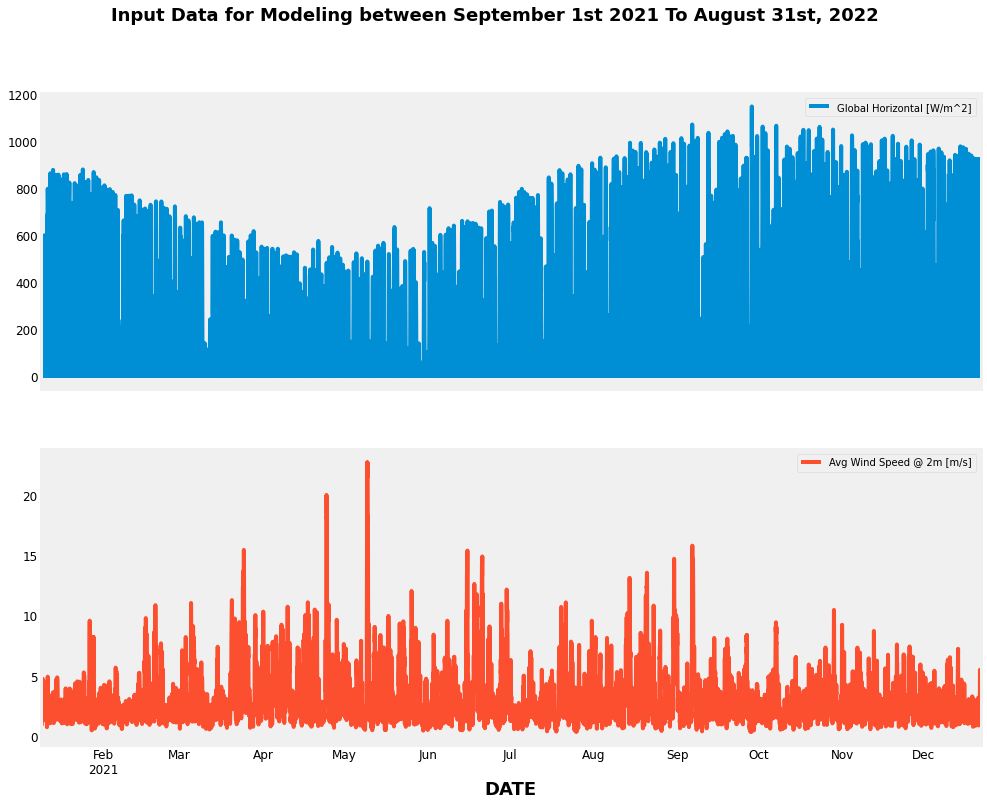

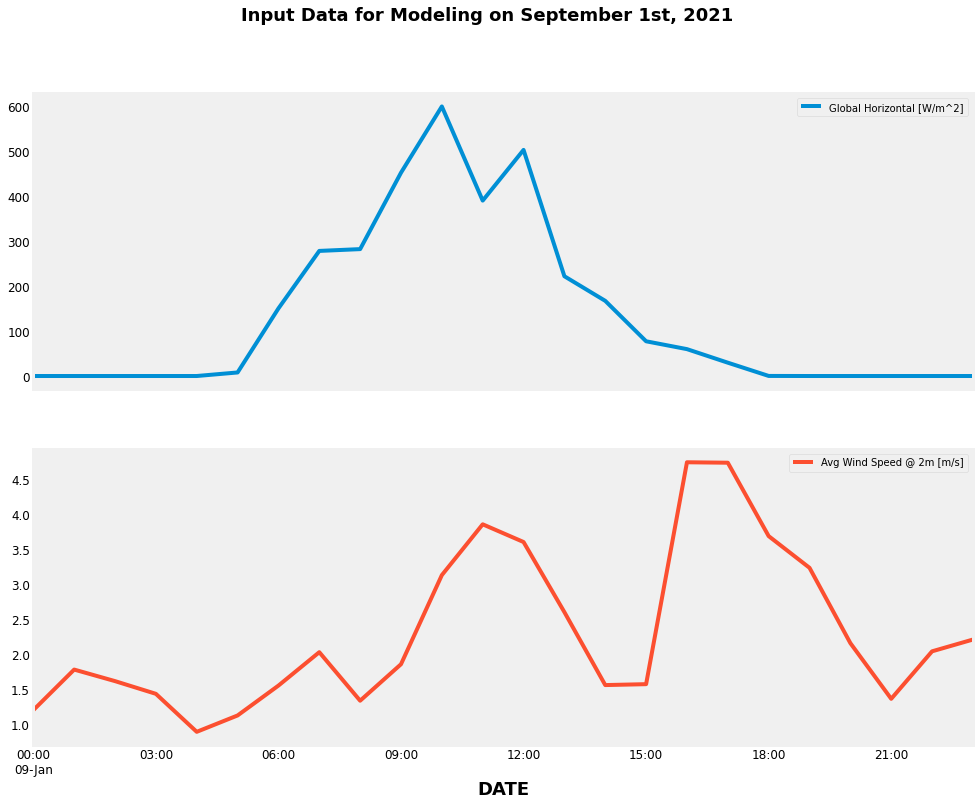

In [ ]:
# Data Cleaning - Spring
df.fillna(0, inplace=True)
df1 = df['Global Horizontal [W/m^2]']
df1[df1 < 0] = 0

plot_cols = ['Global Horizontal [W/m^2]', 'Avg Wind Speed @ 2m [m/s]']
plot_features = df[plot_cols]
#plot_features.index = df['Date_time']
_ = plot_features.plot(subplots=True, figsize=(15, 12))

# Set x-axis label
plt.xlabel('DATE', weight='bold').set_fontsize('18')
plt.suptitle('Input Data for Modeling between September 1st 2021 To August 31st, 2022', weight='bold').set_fontsize('18')

plot_features = df[plot_cols][:24]
#plot_features.index = df.Date_time[:24]
_ = plot_features.plot(subplots=True, figsize=(15, 12))

# Set x-axis label
plt.xlabel('DATE', weight='bold').set_fontsize('18')
plt.suptitle('Input Data for Modeling on September 1st, 2021', weight='bold').set_fontsize('18')

# Saving the Images:
plt.savefig('Input Data for Modeling.png')

**Obtain Average Wind Speed Data and Scale it**

In [ ]:
df_windspeed = df[['Avg Wind Speed @ 2m [m/s]']]

# Scale the input data:
scaler = StandardScaler()
df_windspeed = scaler.fit_transform(df_windspeed)

df_windspeed = df_windspeed.squeeze()
df_windspeed.shape

(8327,)

**Plot the Wind Speed Data**

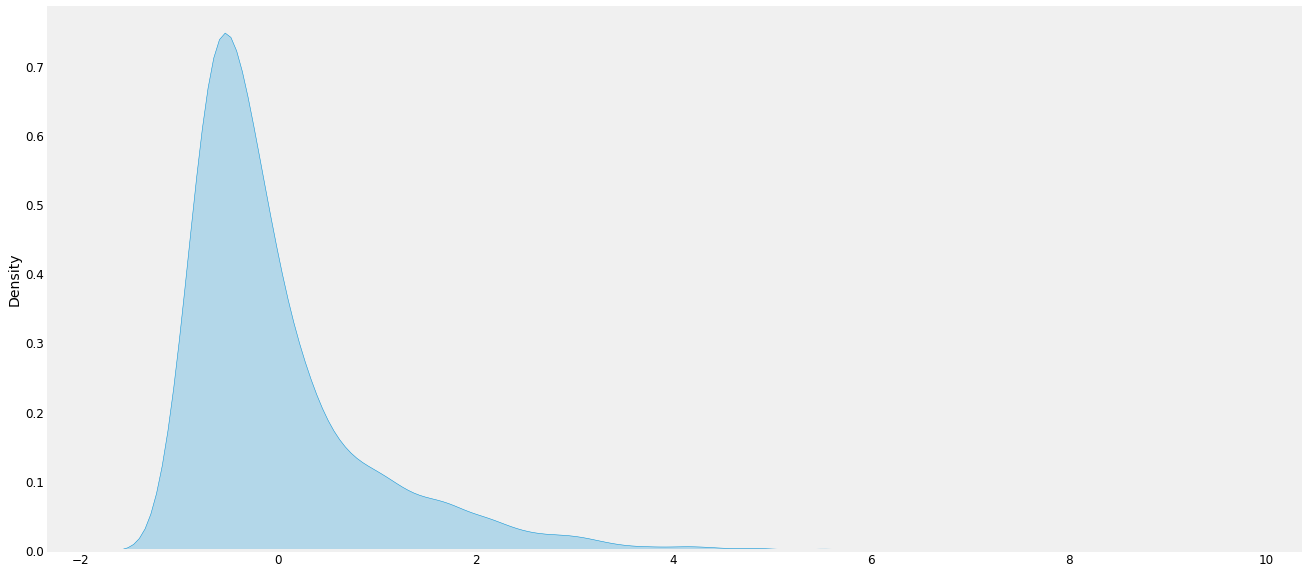

In [ ]:
plt.figure(figsize=(20, 10))
sns.kdeplot(data = df_windspeed, shade='True')

**Obtain Global Horizontal Irradiance (GHI) Data**

In [ ]:
df_GHI = df[['Global Horizontal [W/m^2]']]

# Scale the input data:
scaler = StandardScaler()
df_GHI = scaler.fit_transform(df_GHI)

df_GHI = df_GHI.squeeze()
df_GHI.shape

(8327,)

**Plot the GHI Data**

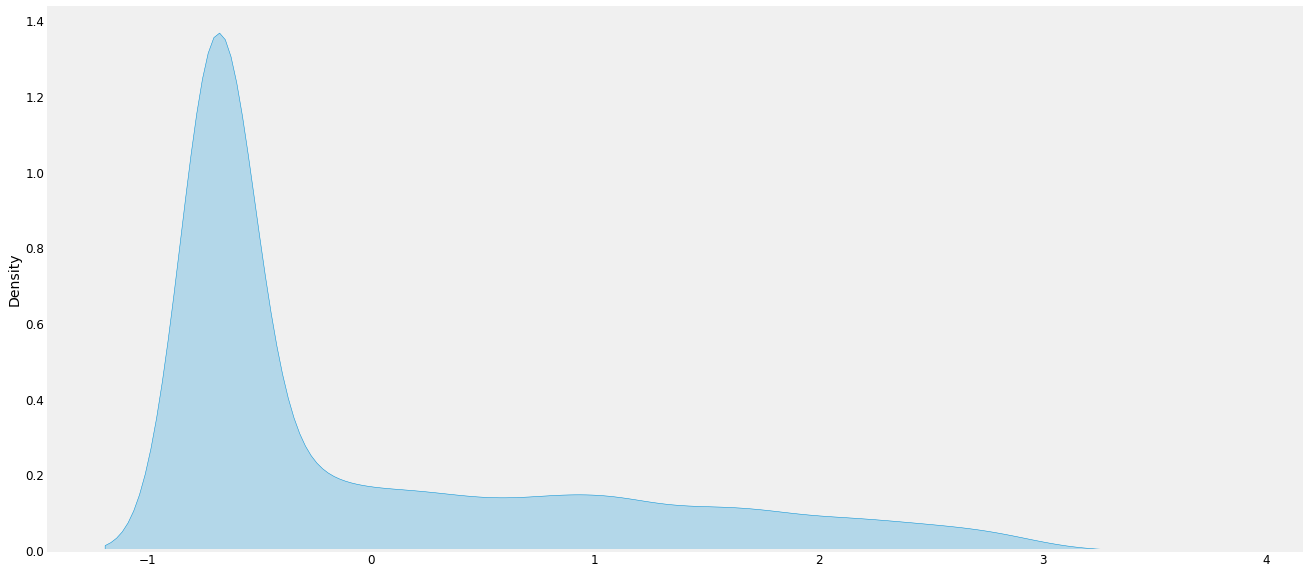

In [ ]:
plt.figure(figsize=(20, 10))
sns.kdeplot(data = df_GHI, shade='True')

**Define the Time Window - Wind Speed**

To forecast the next step given the previous 20 steps, first create a dataset of 20-step windows for training.

In [ ]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

**Split the Dataset - 80% train set and 20% test set:**

In [ ]:
window_size = 24
split_time = 6662
time = np.arange(8327)

time_train = time[:split_time]
x_train = df_windspeed[:split_time]
time_valid = time[split_time:]
x_valid = df_windspeed[split_time:]

train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

print('=================================================================')
print("Training Shape:", train_set.element_spec)
print("Validation/Testing Shape:", valid_set.element_spec)
print('=================================================================')

Training Shape: (TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))
Validation/Testing Shape: (TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))


**Define the Metrics**

In [ ]:
def CORR(pred, true):
    u = ((true - true.mean(0)) * (pred - pred.mean(0))).sum(0)
    d = np.sqrt(((true - true.mean(0)) ** 2 * (pred - pred.mean(0)) ** 2).sum(0))
    return (u / d).mean(-1)

def MAE(pred, true):
    return np.mean(np.abs(pred - true))

def MSE(pred, true):
    return np.mean((pred - true) ** 2)

def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))

def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))

def metric(pred, true):
    #corr = CORR(pred, true)
    mae = MAE(pred, true)
    mse = MSE(pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)

    return mae, mse, rmse, mape

##**Baseline - Persistence Model:**

Before building a trainable model, lets first build a performance baseline as a point for comparison with the later more complicated models.

Naive predictions (just predict the last observed value):

In [ ]:
from tensorflow.python.ops.gen_dataset_ops import MapDefun
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

# First Convert the Data
train_data = list(train_set)
X_train = np.concatenate([train_data[n][0] for n in range(0, len(train_data))])
y_train = np.concatenate([train_data[n][1] for n in range(0, len(train_data))])

val_data = list(valid_set)
X_val = np.concatenate([val_data[n][0] for n in range(0, len(val_data))])
y_val = np.concatenate([val_data[n][1] for n in range(0, len(val_data))])

y_pred_naive = X_val[:, -1]
np.mean(keras.losses.mean_squared_error(y_val, y_pred_naive))

## Instantiate and evaluate this model:
performance = {}

baseline = y_pred_naive
performance['Baseline'] = MAE(y_pred_naive, y_val)

# Evaluation in terms of other Metrics

mae = MAE(y_pred_naive, y_val)
mse = MSE(y_pred_naive, y_val)
rmse = RMSE(y_pred_naive, y_val)
mape = MAPE(y_pred_naive, y_val)

print('=============================================')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Square Error: {mse}')
print(f'Root Mean Square Error: {rmse}')
print(f'Mean Absolute Percentage Error: {mape}')
print('==============================================')

Mean Absolute Error: 0.33463370244868756
Mean Square Error: 0.21543208019090906
Root Mean Square Error: 0.4641466149730159
Mean Absolute Percentage Error: 2.806965088401167


##**Linear Model**

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "Linear_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

model.fit(X_train, y_train, epochs=200,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states])

IPython.display.clear_output()

**Make Predictions and Perform Evaluations with the Model**

In [ ]:
y_pred_linear = model.predict(X_val)
performance['Linear Model'] = MAE(y_pred_linear, y_val)

# Evaluation in terms of other Metrics

mae = MAE(y_pred_linear, y_val)
mse = MSE(y_pred_linear, y_val)
rmse = RMSE(y_pred_linear, y_val)
mape = MAPE(y_pred_linear, y_val)

print('=============================================')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Square Error: {mse}')
print(f'Root Mean Square Error: {rmse}')
print(f'Mean Absolute Percentage Error: {mape}')
print('==============================================')

52/52 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.608167445877435
Mean Square Error: 0.6732316117845896
Root Mean Square Error: 0.8205069236664548
Mean Absolute Percentage Error: 3.7445595158732106


**View the Predictions**

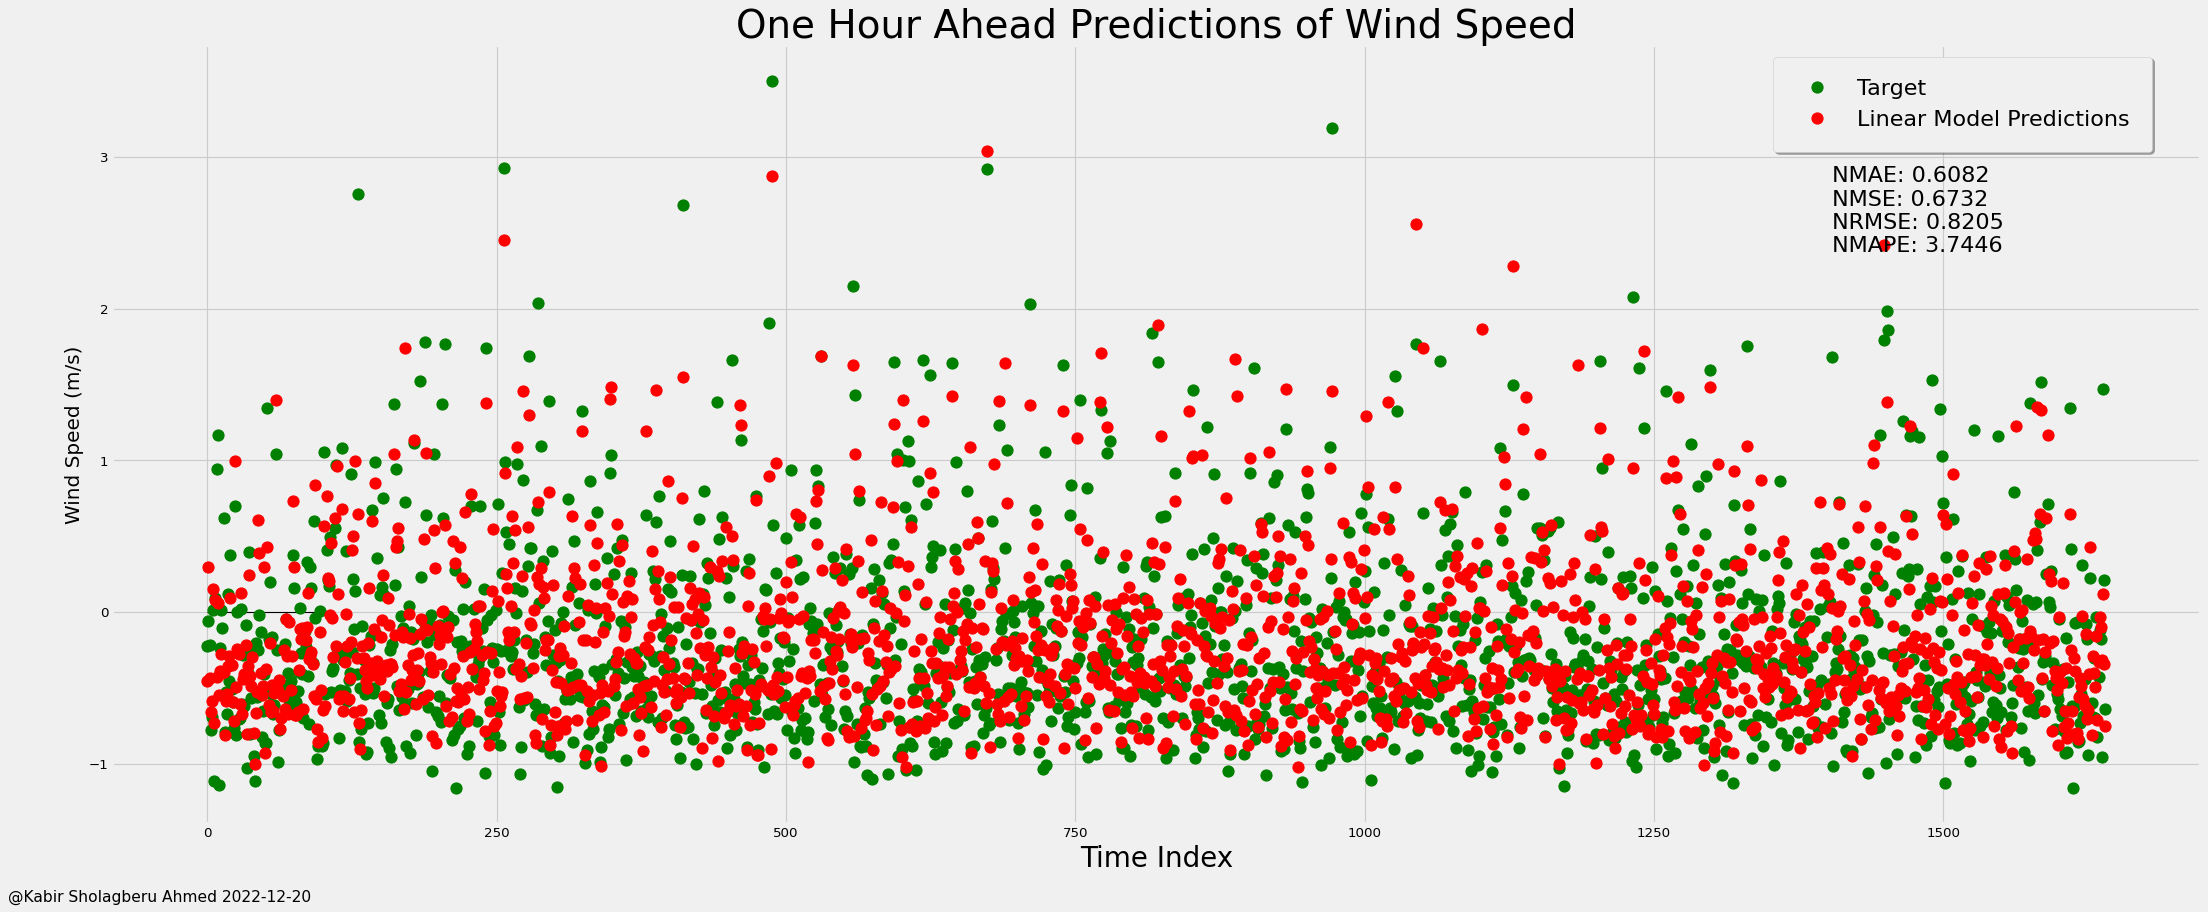

In [ ]:
today = date.today()
figure(figsize=(30, 12), dpi=80)
plt.clf()
plt.style.use('fivethirtyeight')
plt.plot(y_val, "bo", markersize=10, label='Target', color='green')
plt.plot(y_pred_linear, "bo", markersize=10, label='Linear Model Predictions', color='red')
plt.xlabel('Time Index', fontdict = {'fontsize': '25', 'fontweight' : '10'})
plt.ylabel('Wind Speed (m/s)', fontdict = {'fontsize': '18', 'fontweight' : '15'})
plt.title('One Hour Ahead Predictions of Wind Speed', fontdict = {'fontsize': '35', 'fontweight' : '15'})
plt.hlines(0, 0, 100, linewidth=1)
plt.legend(loc = 2, bbox_to_anchor = (0.79, 1.0), ncol = 1, frameon=True, fontsize = '20', fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.text(0.82, 0.73, ' NMAE: {} \n NMSE: {} \n NRMSE: {} \n NMAPE: {}'.format(np.round(mae, 4), np.round(mse, 4), np.round(rmse, 4), np.round(mape, 4)),
         fontsize=20, fontfamily='Georgia', color='k', fontweight = 20,
         ha='left', va='bottom',
         transform=plt.gca().transAxes);
plt.annotate(f"@Kabir Sholagberu Ahmed {today}",
             xy=(1, 1),  xycoords='data',
             xytext=(-0.05, -0.10), textcoords='axes fraction',
             color='black')
plt.savefig('One Hour Ahead Predictions of Wind Speed.png')
plt.show()

###**HYPERPARAMETER TUNING - LINEAR MODEL**

(0.001, 0.01, 0.0, 2.0)

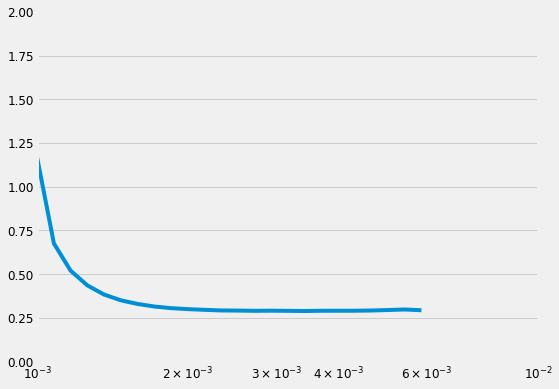

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "Linear_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

history = model.fit(X_train, y_train, epochs=200,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states, lr_schedule])

IPython.display.clear_output()

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-3, 1e-2, 0, 2])

**Obtain the Best Model Parameters, make Pedictions and Evaluate it**

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

optimizer = keras.optimizers.Adam(lr=3e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "Linear_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

model.fit(X_train, y_train, epochs=200,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states, lr_schedule])

IPython.display.clear_output()

y_pred_linear_optimized = model.predict(X_val)
performance['Optmized Linear Model'] = MAE(y_pred_linear_optimized, y_val)

# Evaluation in terms of other Metrics

mae = MAE(y_pred_linear_optimized, y_val)
mse = MSE(y_pred_linear_optimized, y_val)
rmse = RMSE(y_pred_linear_optimized, y_val)
mape = MAPE(y_pred_linear_optimized, y_val)

print('=============================================')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Square Error: {mse}')
print(f'Root Mean Square Error: {rmse}')
print(f'Mean Absolute Percentage Error: {mape}')
print('==============================================')

52/52 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.6152607209204715
Mean Square Error: 0.6891202923774994
Root Mean Square Error: 0.830132695644196
Mean Absolute Percentage Error: 3.7988588070120266


**Visualize the Model**

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


##**DENSE Model**

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "Dense_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

model.fit(X_train, y_train, epochs=200,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states])

IPython.display.clear_output()

**Make Predictions and Perform Evaluations with the Model**

In [ ]:
y_pred_dense = model.predict(X_val)
performance['DENSE Model'] = MAE(y_pred_dense, y_val)

# Evaluation in terms of other Metrics

mae = MAE(y_pred_dense, y_val)
mse = MSE(y_pred_dense, y_val)
rmse = RMSE(y_pred_dense, y_val)
mape = MAPE(y_pred_dense, y_val)

print('=============================================')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Square Error: {mse}')
print(f'Root Mean Square Error: {rmse}')
print(f'Mean Absolute Percentage Error: {mape}')
print('==============================================')

52/52 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.5971989782854216
Mean Square Error: 0.6605005866089912
Root Mean Square Error: 0.8127118718272739
Mean Absolute Percentage Error: 3.6284978783096804


**View the Predictions**

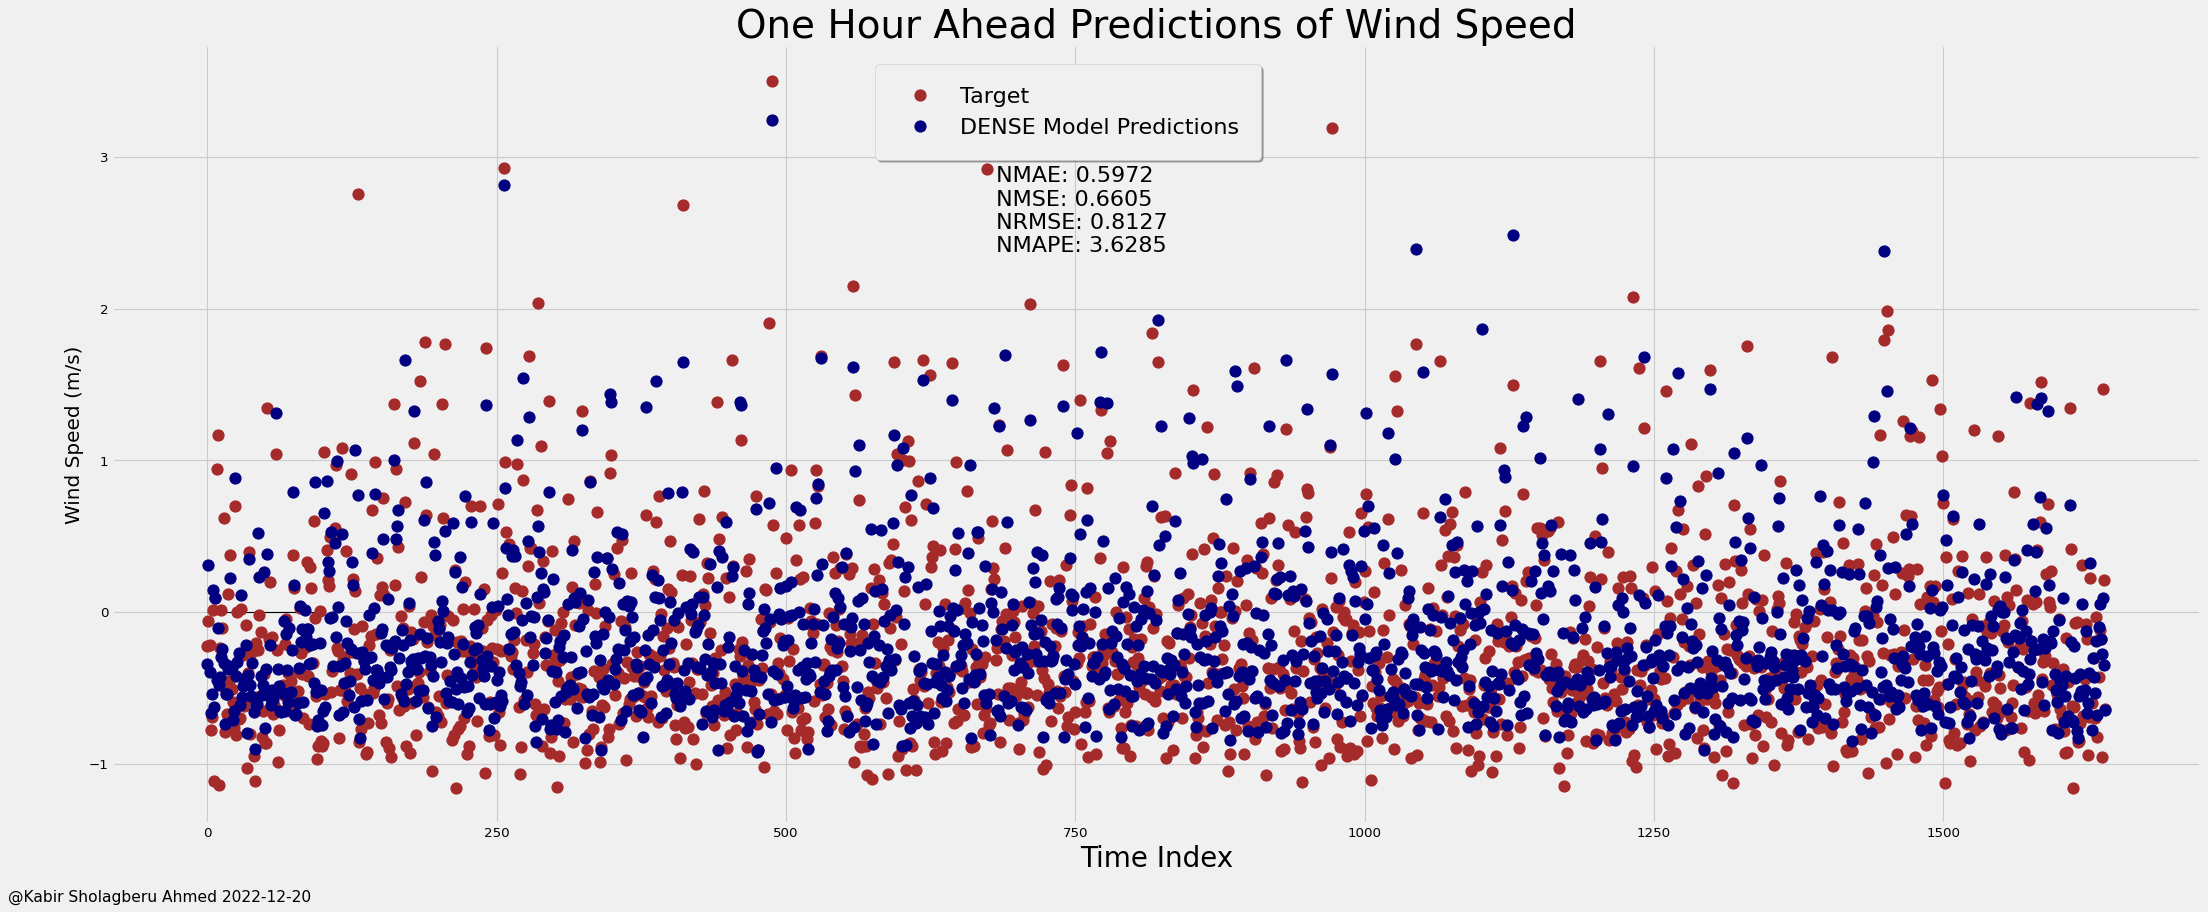

In [ ]:
today = date.today()
figure(figsize=(30, 12), dpi=80)
plt.clf()
plt.style.use('fivethirtyeight')
plt.plot(y_val, "bo", markersize=10, label='Target', color='brown')
plt.plot(y_pred_dense, "bo", markersize=10, label='DENSE Model Predictions', color='navy')
plt.xlabel('Time Index', fontdict = {'fontsize': '25', 'fontweight' : '10'})
plt.ylabel('Wind Speed (m/s)', fontdict = {'fontsize': '18', 'fontweight' : '15'})
plt.title('One Hour Ahead Predictions of Wind Speed', fontdict = {'fontsize': '35', 'fontweight' : '15'})
plt.hlines(0, 0, 100, linewidth=1)
plt.legend(loc = 2, bbox_to_anchor = (0.36, 0.99), ncol = 1, frameon=True, fontsize = '20', fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.text(0.42, 0.73, ' NMAE: {} \n NMSE: {} \n NRMSE: {} \n NMAPE: {}'.format(np.round(mae, 4), np.round(mse, 4), np.round(rmse, 4), np.round(mape, 4)),
         fontsize=20, fontfamily='Georgia', color='k', fontweight = 20,
         ha='left', va='bottom',
         transform=plt.gca().transAxes);
plt.annotate(f"@Kabir Sholagberu Ahmed {today}",
             xy=(1, 1),  xycoords='data',
             xytext=(-0.05, -0.10), textcoords='axes fraction',
             color='black')
plt.savefig('One Hour Ahead Predictions of Wind Speed.png')
plt.show()

### **HYPERPARAMETER TUNING - DENSE MODEL**

(0.001, 0.01, 0.0, 1.0)

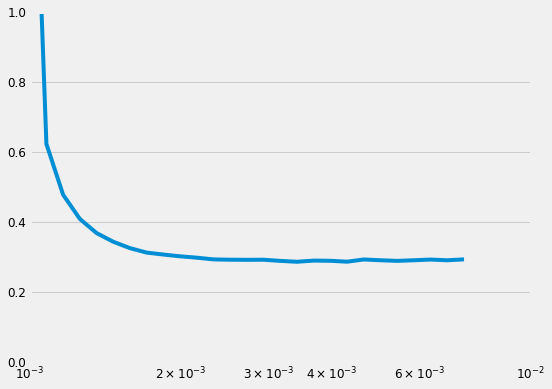

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "Dense_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

history = model.fit(X_train, y_train, epochs=200,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states, lr_schedule])

IPython.display.clear_output()

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-3, 1e-2, 0, 1])

**Obtain the Best Model Parameters, make Pedictions and Evaluate it**

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(lr=3.5e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "Dense_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

model.fit(X_train, y_train, epochs=200,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states, lr_schedule])

IPython.display.clear_output()

y_pred_dense_optimized = model.predict(X_val)
performance['Optmized Dense Model'] = MAE(y_pred_dense_optimized, y_val)

# Evaluation in terms of other Metrics

mae = MAE(y_pred_dense_optimized, y_val)
mse = MSE(y_pred_dense_optimized, y_val)
rmse = RMSE(y_pred_dense_optimized, y_val)
mape = MAPE(y_pred_dense_optimized, y_val)

print('=============================================')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Square Error: {mse}')
print(f'Root Mean Square Error: {rmse}')
print(f'Mean Absolute Percentage Error: {mape}')
print('==============================================')

52/52 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.5956188254534694
Mean Square Error: 0.6585742944911785
Root Mean Square Error: 0.8115259050031481
Mean Absolute Percentage Error: 3.737421802611987


**Visualize the Model**

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                250       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________


##**LSTM Model**

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Reshape the Input:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 24, 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1, 1))

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=False,
                    input_shape=(24, 1)),
  keras.layers.LSTM(100, return_sequences=True, stateful=False),
  keras.layers.Dense(1),
])

optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "Lstm_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

model.fit(X_train, y_train, epochs=200, batch_size=32,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states])

IPython.display.clear_output()

**Make Predictions and Perform Evaluations with the Model**

In [ ]:
y_pred_lstm = model.predict(X_val)
performance['LSTM Model'] = MAE(y_pred_lstm, y_val)

# Evaluation in terms of other Metrics

mae = MAE(y_pred_lstm, y_val)
mse = MSE(y_pred_lstm, y_val)
rmse = RMSE(y_pred_lstm, y_val)
mape = MAPE(y_pred_lstm, y_val)

print('=============================================')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Square Error: {mse}')
print(f'Root Mean Square Error: {rmse}')
print(f'Mean Absolute Percentage Error: {mape}')
print('==============================================')

52/52 [==============================] - 1s 3ms/step
Mean Absolute Error: 0.5626317076543493
Mean Square Error: 0.4915350815378231
Root Mean Square Error: 0.7010956293814868
Mean Absolute Percentage Error: 1.704262272283729


**View the Predictions**

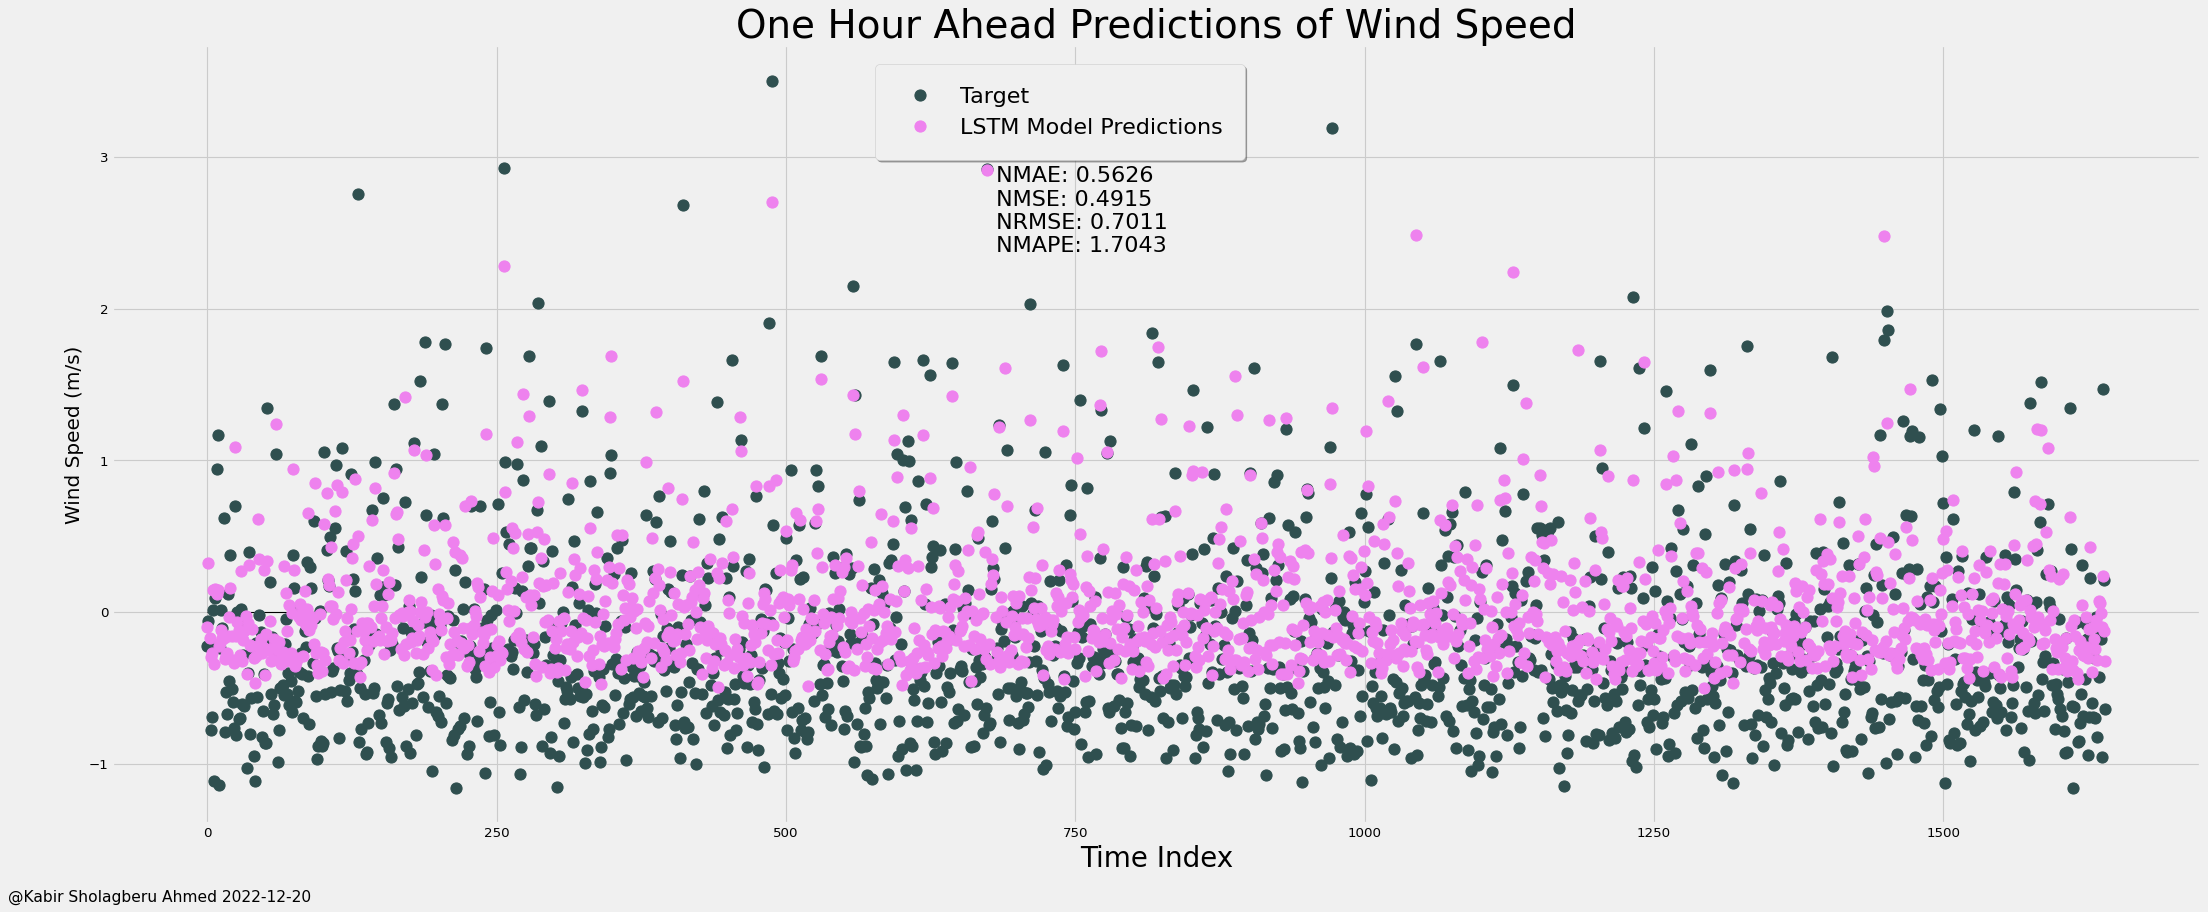

In [ ]:
y_pred_lstm = y_pred_lstm[:, -1, -1]
today = date.today()
figure(figsize=(30, 12), dpi=80)
plt.clf()
plt.style.use('fivethirtyeight')
plt.plot(y_val, "bo", markersize=10, label='Target', color='darkslategray')
plt.plot(y_pred_lstm, "bo", markersize=10, label='LSTM Model Predictions', color='violet')
plt.xlabel('Time Index', fontdict = {'fontsize': '25', 'fontweight' : '10'})
plt.ylabel('Wind Speed (m/s)', fontdict = {'fontsize': '18', 'fontweight' : '15'})
plt.title('One Hour Ahead Predictions of Wind Speed', fontdict = {'fontsize': '35', 'fontweight' : '15'})
plt.hlines(0, 0, 100, linewidth=1)
plt.legend(loc = 2, bbox_to_anchor = (0.36, 0.99), ncol = 1, frameon=True, fontsize = '20', fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.text(0.42, 0.73, ' NMAE: {} \n NMSE: {} \n NRMSE: {} \n NMAPE: {}'.format(np.round(mae, 4), np.round(mse, 4), np.round(rmse, 4), np.round(mape, 4)),
         fontsize=20, fontfamily='Georgia', color='k', fontweight = 20,
         ha='left', va='bottom',
         transform=plt.gca().transAxes);
plt.annotate(f"@Kabir Sholagberu Ahmed {today}",
             xy=(1, 1),  xycoords='data',
             xytext=(-0.05, -0.10), textcoords='axes fraction',
             color='black')
plt.savefig('One Hour Ahead Predictions of Wind Speed.png')
plt.show()

###**HYPERPARAMETER TUNING - LSTM MODEL**

(0.001, 0.01, 0.0, 2.0)

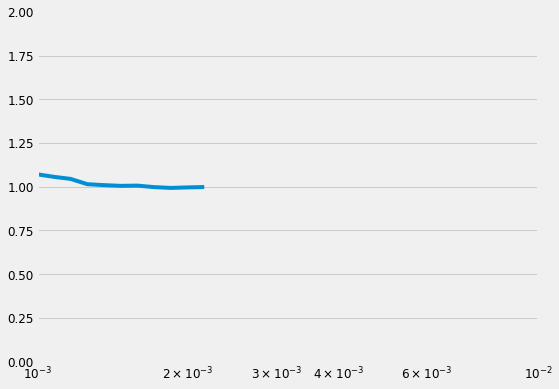

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=False,
                    input_shape=(24, 1)),
  keras.layers.LSTM(100, return_sequences=True, stateful=False),
  keras.layers.Dense(1),
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "Lstm_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

history = model.fit(X_train, y_train, epochs=200,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states, lr_schedule])

IPython.display.clear_output()

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-3, 1e-2, 0, 2])

**Obtain the Best Model Parameters, make Pedictions and Evaluate it**

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=False,
                    input_shape=(24, 1)),
  keras.layers.LSTM(100, return_sequences=True, stateful=False),
  keras.layers.Dense(1),
])

optimizer = keras.optimizers.Adam(lr=2.5e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "Lstm_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

model.fit(X_train, y_train, epochs=200,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states, lr_schedule])

IPython.display.clear_output()

y_pred_lstm_optimized = model.predict(X_val)
performance['Optmized Lstm Model'] = MAE(y_pred_lstm_optimized, y_val)

# Evaluation in terms of other Metrics

mae = MAE(y_pred_lstm_optimized, y_val)
mse = MSE(y_pred_lstm_optimized, y_val)
rmse = RMSE(y_pred_lstm_optimized, y_val)
mape = MAPE(y_pred_lstm_optimized, y_val)

print('=============================================')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Square Error: {mse}')
print(f'Root Mean Square Error: {rmse}')
print(f'Mean Absolute Percentage Error: {mape}')
print('==============================================')

52/52 [==============================] - 1s 3ms/step
Mean Absolute Error: 0.5764702350971851
Mean Square Error: 0.5043111692249966
Root Mean Square Error: 0.7101486951512315
Mean Absolute Percentage Error: 1.6976797687812635


**Visualize the Model**

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 24, 100)           80400     
                                                                 
 dense (Dense)               (None, 24, 1)             101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


##**1-Dimensional Convolutional Model**

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Reshape the Input:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 24, 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1, 1))

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "tcnn_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

model.fit(X_train, y_train, epochs=200, batch_size=32,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states])

IPython.display.clear_output()

**Make Predictions and Perform Evaluations with the Model**

In [ ]:
model = keras.models.load_model("tcnn_Model.h5")
y_pred_tcnn = model.predict(X_val)
performance['TCNN Model'] = MAE(y_pred_tcnn, y_val)

# Evaluation in terms of other Metrics

mae = MAE(y_pred_tcnn, y_val)
mse = MSE(y_pred_tcnn, y_val)
rmse = RMSE(y_pred_tcnn, y_val)
mape = MAPE(y_pred_tcnn, y_val)

print('=============================================')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Square Error: {mse}')
print(f'Root Mean Square Error: {rmse}')
print(f'Mean Absolute Percentage Error: {mape}')
print('==============================================')

52/52 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.542516303379376
Mean Square Error: 0.46365879972501983
Root Mean Square Error: 0.6809249589529083
Mean Absolute Percentage Error: 1.6833967361521314


**View the Predictions**

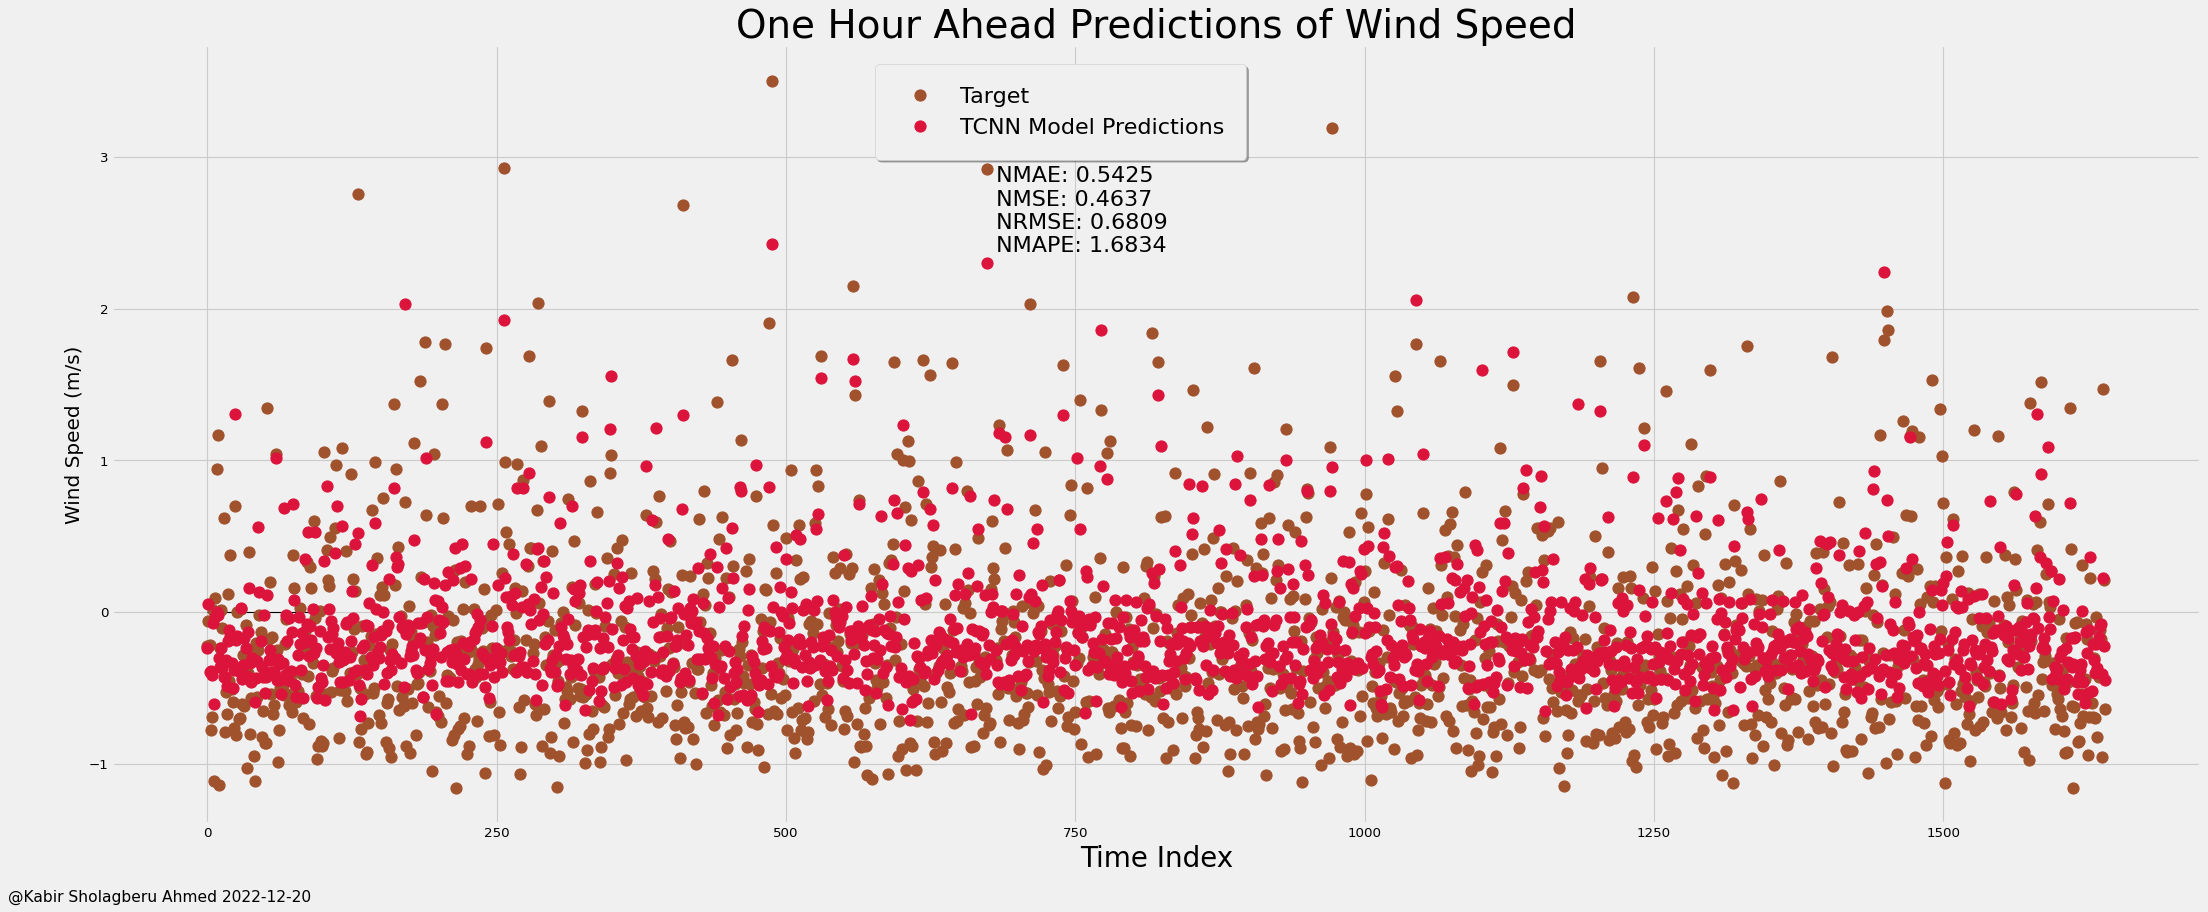

In [ ]:
y_pred_tcnn = y_pred_tcnn[:, -1, -1]
today = date.today()
figure(figsize=(30, 12), dpi=80)
plt.clf()
plt.style.use('fivethirtyeight')
plt.plot(y_val, "bo", markersize=10, label='Target', color='sienna')
plt.plot(y_pred_tcnn, "bo", markersize=10, label='TCNN Model Predictions', color='crimson')
plt.xlabel('Time Index', fontdict = {'fontsize': '25', 'fontweight' : '10'})
plt.ylabel('Wind Speed (m/s)', fontdict = {'fontsize': '18', 'fontweight' : '15'})
plt.title('One Hour Ahead Predictions of Wind Speed', fontdict = {'fontsize': '35', 'fontweight' : '15'})
plt.hlines(0, 0, 100, linewidth=1)
plt.legend(loc = 2, bbox_to_anchor = (0.36, 0.99), ncol = 1, frameon=True, fontsize = '20', fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.text(0.42, 0.73, ' NMAE: {} \n NMSE: {} \n NRMSE: {} \n NMAPE: {}'.format(np.round(mae, 4), np.round(mse, 4), np.round(rmse, 4), np.round(mape, 4)),
         fontsize=20, fontfamily='Georgia', color='k', fontweight = 20,
         ha='left', va='bottom',
         transform=plt.gca().transAxes);
plt.annotate(f"@Kabir Sholagberu Ahmed {today}",
             xy=(1, 1),  xycoords='data',
             xytext=(-0.05, -0.10), textcoords='axes fraction',
             color='black')
plt.savefig('One Hour Ahead Predictions of Wind Speed.png')
plt.show()

##**HYPERPARAMETER TUNING - TCNN MODEL**

(0.001, 0.01, 0.0, 2.0)

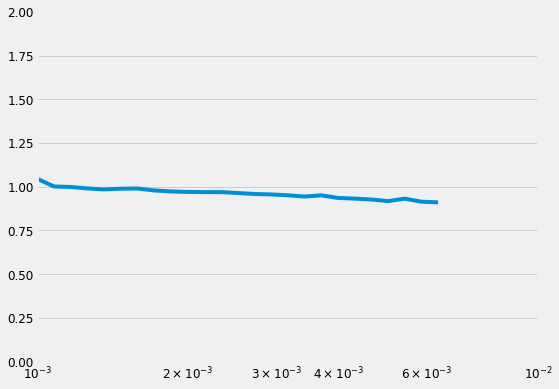

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "tcnn_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

history = model.fit(X_train, y_train, epochs=200,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states, lr_schedule])

IPython.display.clear_output()

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-3, 1e-2, 0, 2])

**Obtain the Best Model Parameters, make Pedictions and Evaluate it**

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

optimizer = keras.optimizers.Adam(lr=6.3e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "tcnn_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

model.fit(X_train, y_train, epochs=200,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states, lr_schedule])

IPython.display.clear_output()

y_pred_tcnn_optimized = model.predict(X_val)
performance['Optmized TCNN Model'] = MAE(y_pred_tcnn_optimized, y_val)

# Evaluation in terms of other Metrics

mae = MAE(y_pred_tcnn_optimized, y_val)
mse = MSE(y_pred_tcnn_optimized, y_val)
rmse = RMSE(y_pred_tcnn_optimized, y_val)
mape = MAPE(y_pred_tcnn_optimized, y_val)

print('=============================================')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Square Error: {mse}')
print(f'Root Mean Square Error: {rmse}')
print(f'Mean Absolute Percentage Error: {mape}')
print('==============================================')

52/52 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.5363574195963375
Mean Square Error: 0.505279213389117
Root Mean Square Error: 0.7108299468854116
Mean Absolute Percentage Error: 2.1455088716690107


**Visualize the Model**

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          96        
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_2 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_3 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_4 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_5 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_6 (Conv1D)           (None, None, 1)           3

##**Recurrent Autoencoders**

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Reshape the Input:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 24, 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1, 1))

recurrent_encoder = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=False,
                    input_shape=(24, 1)),
  keras.layers.LSTM(100, return_sequences=True, stateful=False),
  keras.layers.Dense(1)
])

recurrent_decoder = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=False,
                    input_shape=(24, 1)),
  keras.layers.LSTM(100, return_sequences=True, stateful=False),
  keras.layers.Dense(1),
])

model = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "Recurrent_Autoencoder_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

model.fit(X_train, y_train, epochs=200, batch_size=32,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states])

IPython.display.clear_output()

**Make Predictions and Perform Evaluations with the Model**

In [ ]:
model = keras.models.load_model("Recurrent_Autoencoder_Model.h5")
y_pred_ae = model.predict(X_val)
performance['AUTOENCODER Model'] = MAE(y_pred_ae, y_val)

# Evaluation in terms of other Metrics

mae = MAE(y_pred_ae, y_val)
mse = MSE(y_pred_ae, y_val)
rmse = RMSE(y_pred_ae, y_val)
mape = MAPE(y_pred_ae, y_val)

print('=============================================')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Square Error: {mse}')
print(f'Root Mean Square Error: {rmse}')
print(f'Mean Absolute Percentage Error: {mape}')
print('==============================================')

52/52 [==============================] - 1s 5ms/step
Mean Absolute Error: 1.0734177733735348
Mean Square Error: 1.9248040163422606
Root Mean Square Error: 1.3873730631456922
Mean Absolute Percentage Error: 3.1437126248226175


**View the Predictions**

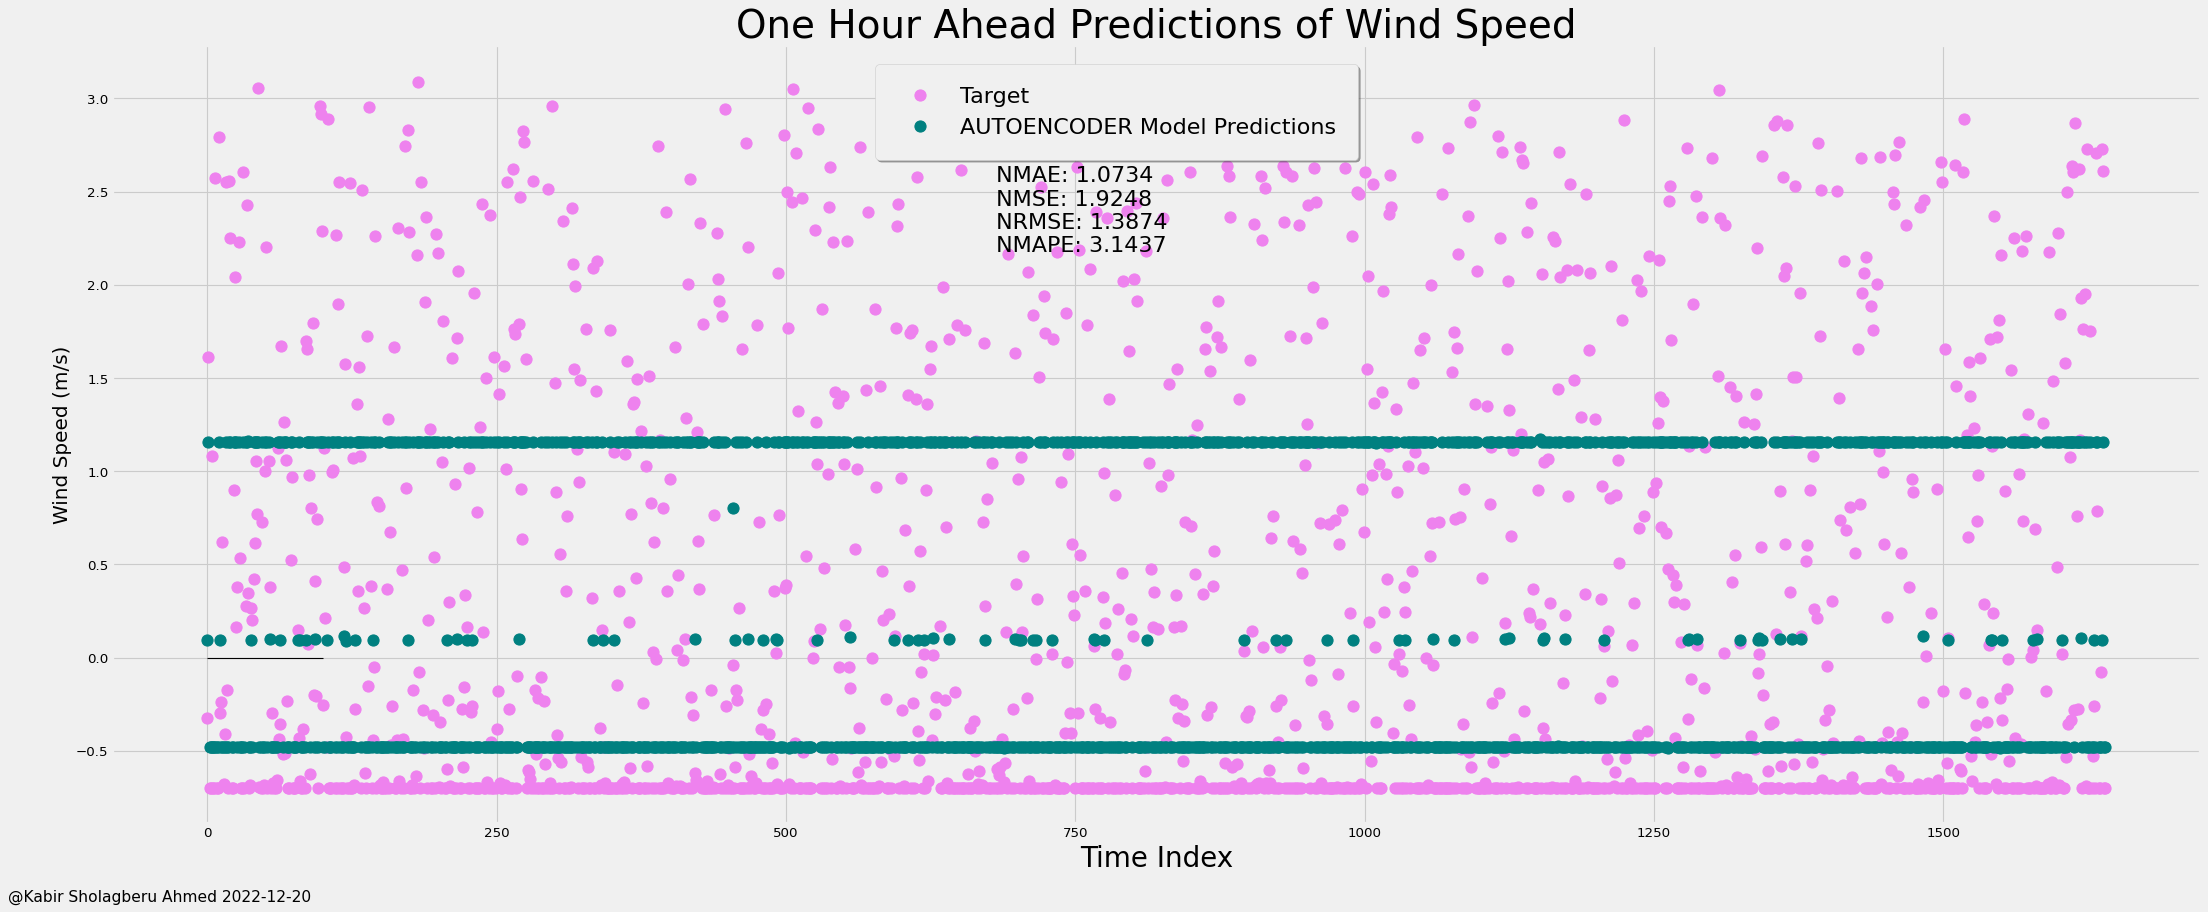

In [ ]:
y_pred_ae = y_pred_ae[:, -1, -1]
today = date.today()
figure(figsize=(30, 12), dpi=80)
plt.clf()
plt.style.use('fivethirtyeight')
plt.plot(y_val, "bo", markersize=10, label='Target', color='violet')
plt.plot(y_pred_ae, "bo", markersize=10, label='AUTOENCODER Model Predictions', color='teal')
plt.xlabel('Time Index', fontdict = {'fontsize': '25', 'fontweight' : '10'})
plt.ylabel('Wind Speed (m/s)', fontdict = {'fontsize': '18', 'fontweight' : '15'})
plt.title('One Hour Ahead Predictions of Wind Speed', fontdict = {'fontsize': '35', 'fontweight' : '15'})
plt.hlines(0, 0, 100, linewidth=1)
plt.legend(loc = 2, bbox_to_anchor = (0.36, 0.99), ncol = 1, frameon=True, fontsize = '20', fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.text(0.42, 0.73, ' NMAE: {} \n NMSE: {} \n NRMSE: {} \n NMAPE: {}'.format(np.round(mae, 4), np.round(mse, 4), np.round(rmse, 4), np.round(mape, 4)),
         fontsize=20, fontfamily='Georgia', color='k', fontweight = 20,
         ha='left', va='bottom',
         transform=plt.gca().transAxes);
plt.annotate(f"@Kabir Sholagberu Ahmed {today}",
             xy=(1, 1),  xycoords='data',
             xytext=(-0.05, -0.10), textcoords='axes fraction',
             color='black')
plt.savefig('One Hour Ahead Predictions of Wind Speed.png')
plt.show()

##**HYPERPARAMETER TUNING - AUTOENCODER MODEL**

(0.001, 0.01, 0.0, 2.0)

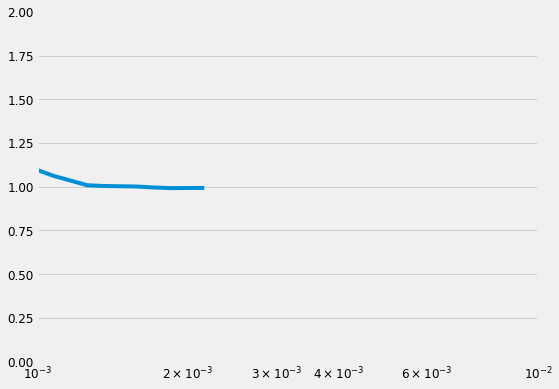

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

recurrent_encoder = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=False,
                    input_shape=(24, 1)),
  keras.layers.LSTM(100, return_sequences=True, stateful=False),
  keras.layers.Dense(1)
])

recurrent_decoder = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=False,
                    input_shape=(24, 1)),
  keras.layers.LSTM(100, return_sequences=True, stateful=False),
  keras.layers.Dense(1),
])

model = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "AUTOENCODER_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

history = model.fit(X_train, y_train, epochs=200,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states, lr_schedule])

IPython.display.clear_output()

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-3, 1e-2, 0, 2])

**Obtain the Best Model Parameters, make Pedictions and Evaluate it**

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

recurrent_encoder = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=False,
                    input_shape=(24, 1)),
  keras.layers.LSTM(100, return_sequences=True, stateful=False),
  keras.layers.Dense(1)
])

recurrent_decoder = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=False,
                    input_shape=(24, 1)),
  keras.layers.LSTM(100, return_sequences=True, stateful=False),
  keras.layers.Dense(1),
])

model = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

optimizer = keras.optimizers.Adam(lr=2.5e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "AUTOENCODER_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

model.fit(X_train, y_train, epochs=200,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states, lr_schedule])

IPython.display.clear_output()

y_pred_ae_optimized = model.predict(X_val)
performance['Optmized AUTOENCODER Model'] = MAE(y_pred_ae_optimized, y_val)

# Evaluation in terms of other Metrics

mae = MAE(y_pred_ae_optimized, y_val)
mse = MSE(y_pred_ae_optimized, y_val)
rmse = RMSE(y_pred_ae_optimized, y_val)
mape = MAPE(y_pred_ae_optimized, y_val)

print('=============================================')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Square Error: {mse}')
print(f'Root Mean Square Error: {rmse}')
print(f'Mean Absolute Percentage Error: {mape}')
print('==============================================')

52/52 [==============================] - 2s 5ms/step
Mean Absolute Error: 0.5694243735958545
Mean Square Error: 0.49294448909426936
Root Mean Square Error: 0.7021000563269236
Mean Absolute Percentage Error: 1.6996701019834384


**Visualize the Model**

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 24, 1)             121301    
                                                                 
 sequential_1 (Sequential)   (None, 24, 1)             121301    
                                                                 
Total params: 242,602
Trainable params: 242,602
Non-trainable params: 0
_________________________________________________________________


**Comparison of the Model's Forecast at 1-Hour Ahead based on MAE, MSE, RMSE, MAPE Metrics**

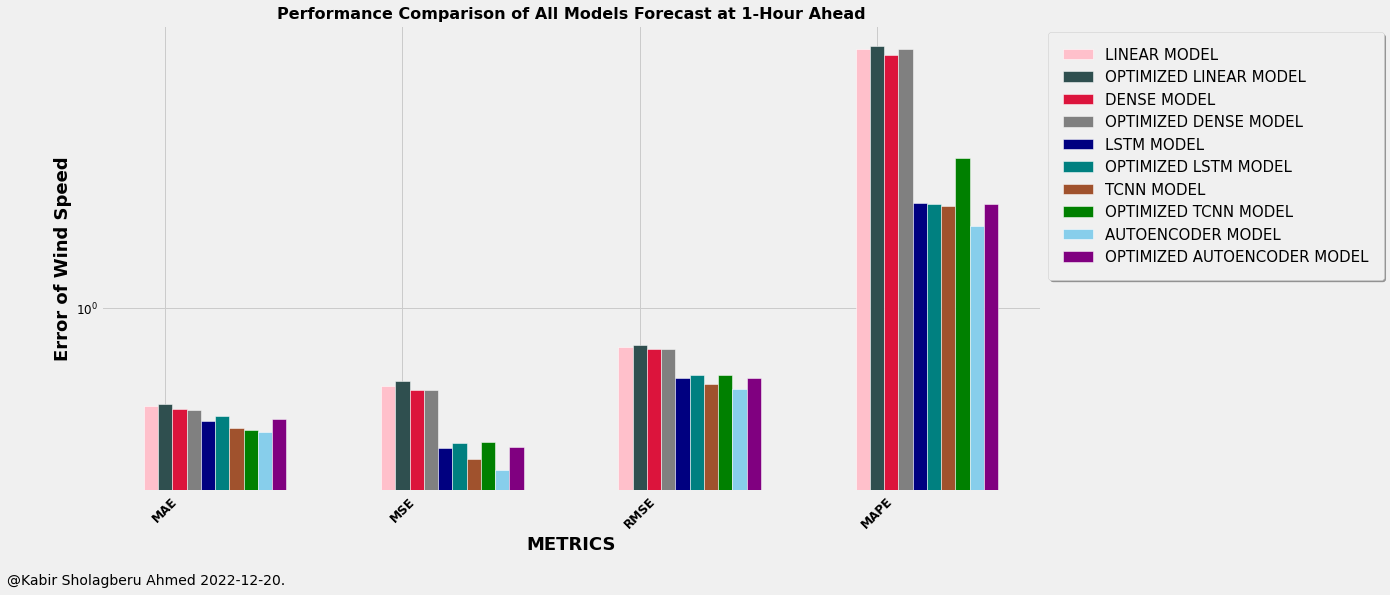

In [ ]:
today = date.today()
#NAIVE = [0.3346, 0.2154, 0.4641, 2.8069]
LINEAR = [0.6081, 0.6732, 0.8205, 3.744]
OPT_LINEAR = [0.6152, 0.6891, 0.8301, 3.7988]
DENSE = [0.5971, 0.6605, 0.8127, 3.6284]
OPT_DENSE = [0.5956, 0.6585, 0.8115, 3.7374]
LSTM = [0.5626, 0.4915, 0.7010, 1.7042]
OPT_LSTM = [0.5764, 0.5043, 0.7101, 1.6976]
TCNN = [0.5425, 0.4636, 0.680, 1.6833]
OPT_TCNN = [0.5363, 0.5052, 0.7108, 2.1455]
AUTOENCODER = [0.5313, 0.4378, 0.6616, 1.5205]
OPT_AUTOENCODER = [0.5694, 0.4929, 0.7021, 1.6996]

N = 4
x = np.arange(N)
width = 0.3

# Set position of bar on X axis
#r1 = np.arange(0, len(LINEAR) * 5, 5)
r1 = np.arange(0, len(LINEAR) * 5, 5)
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]
r4 = [x + width for x in r3]
r5 = [x + width for x in r4]
r6 = [x + width for x in r5]
r7 = [x + width for x in r6]
r8 = [x + width for x in r7]
r9 = [x + width for x in r8]
r10 = [x + width for x in r9]

plt.figure(figsize=(15, 8))
plt.clf()
plt.style.use('fivethirtyeight')
plt.ylabel("Error of Wind Speed", weight='bold').set_fontsize('18')
#plt.bar(r1, NAIVE, width, edgecolor='white', label='NAIVE', color='violet')
plt.bar(r1, LINEAR, width, edgecolor='white', label='LINEAR MODEL', color='pink')
plt.bar(r2, OPT_LINEAR, width, edgecolor='white', label='OPTIMIZED LINEAR MODEL', color='darkslategrey')
plt.bar(r3, DENSE, width, edgecolor='white', label='DENSE MODEL', color='crimson')
plt.bar(r4, OPT_DENSE, width, edgecolor='white', label='OPTIMIZED DENSE MODEL', color='gray')
plt.bar(r5, LSTM, width, edgecolor='white', label='LSTM MODEL', color='navy')
plt.bar(r6, OPT_LSTM, width, edgecolor='white', label='OPTIMIZED LSTM MODEL', color='teal')
plt.bar(r7, TCNN, width, edgecolor='white', label='TCNN MODEL', color='sienna')
plt.bar(r8, OPT_TCNN, width, edgecolor='white', label='OPTIMIZED TCNN MODEL', color='green')
plt.bar(r9, AUTOENCODER, width, edgecolor='white', label='AUTOENCODER MODEL', color='skyblue')
plt.bar(r10, OPT_AUTOENCODER, width, edgecolor='white', label='OPTIMIZED AUTOENCODER MODEL', color='purple')

plt.xlabel('METRICS', weight='bold').set_fontsize('18')
plt.xticks([r + width for r in range(0, len(LINEAR) * 5, 5)], ['MAE', 'MSE', 'RMSE', 'MAPE'], rotation=45, size = 12, fontweight='bold')
plt.title('Performance Comparison of All Models Forecast at 1-Hour Ahead', size = 16, fontweight='bold')
plt.legend(loc = 'best', bbox_to_anchor = (1.0, 1.0), ncol = 1, frameon=True, fontsize = '15',
           fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.grid(True)
plt.yscale('log')
plt.annotate(f"@Kabir Sholagberu Ahmed {today}.",
             xy=(1, 1),  xycoords='data',
             xytext=(-0.1, -0.20), textcoords='axes fraction',
             color='black')
plt.savefig('Comparison of the Models Forecast at 1-Hour Ahead based on MAE, MSE, RMSE & MAPE Metrics.png')


#**GLOBAL HORIZONTAL IRRADIANCE (GHI) FORECASTING FRAMEWORK**

**Split the Dataset - 80% train set and 20% test set:**

In [ ]:
window_size = 24
split_time = 6662
time = np.arange(8327)

time_train = time[:split_time]
x_train = df_GHI[:split_time]
time_valid = time[split_time:]
x_valid = df_GHI[split_time:]

train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

print('=================================================================')
print("Training Shape:", train_set.element_spec)
print("Validation/Testing Shape:", valid_set.element_spec)
print('=================================================================')

Training Shape: (TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))
Validation/Testing Shape: (TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))


**Define the Metrics**

In [ ]:
def CORR(pred, true):
    u = ((true - true.mean(0)) * (pred - pred.mean(0))).sum(0)
    d = np.sqrt(((true - true.mean(0)) ** 2 * (pred - pred.mean(0)) ** 2).sum(0))
    return (u / d).mean(-1)

def MAE(pred, true):
    return np.mean(np.abs(pred - true))

def MSE(pred, true):
    return np.mean((pred - true) ** 2)

def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))

def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))

def metric(pred, true):
    #corr = CORR(pred, true)
    mae = MAE(pred, true)
    mse = MSE(pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)

    return mae, mse, rmse, mape

##**Baseline - Persistence Model:**

Before building a trainable model, lets first build a performance baseline as a point for comparison with the later more complicated models.

Naive predictions (just predict the last observed value):

In [ ]:
from tensorflow.python.ops.gen_dataset_ops import MapDefun
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

# First Convert the Data
train_data = list(train_set)
X_train = np.concatenate([train_data[n][0] for n in range(0, len(train_data))])
y_train = np.concatenate([train_data[n][1] for n in range(0, len(train_data))])

val_data = list(valid_set)
X_val = np.concatenate([val_data[n][0] for n in range(0, len(val_data))])
y_val = np.concatenate([val_data[n][1] for n in range(0, len(val_data))])

y_pred_naive = X_val[:, -1]
np.mean(keras.losses.mean_squared_error(y_val, y_pred_naive))

## Instantiate and evaluate this model:
performance = {}

baseline = y_pred_naive
performance['Baseline'] = MAE(y_pred_naive, y_val)

# Evaluation in terms of other Metrics

mae = MAE(y_pred_naive, y_val)
mse = MSE(y_pred_naive, y_val)
rmse = RMSE(y_pred_naive, y_val)
mape = MAPE(y_pred_naive, y_val)

print('=============================================')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Square Error: {mse}')
print(f'Root Mean Square Error: {rmse}')
print(f'Mean Absolute Percentage Error: {mape}')
print('==============================================')

Mean Absolute Error: 0.32804045329504966
Mean Square Error: 0.26194093216944514
Root Mean Square Error: 0.5118016531523175
Mean Absolute Percentage Error: 2.008404977461068


##**Linear Model**

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "Linear_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

model.fit(X_train, y_train, epochs=200,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states])

IPython.display.clear_output()

**Make Predictions and Perform Evaluations with the Model**

In [ ]:
y_pred_linear = model.predict(X_val)
performance['Linear Model'] = MAE(y_pred_linear, y_val)

# Evaluation in terms of other Metrics

mae = MAE(y_pred_linear, y_val)
mse = MSE(y_pred_linear, y_val)
rmse = RMSE(y_pred_linear, y_val)
mape = MAPE(y_pred_linear, y_val)

print('=============================================')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Square Error: {mse}')
print(f'Root Mean Square Error: {rmse}')
print(f'Mean Absolute Percentage Error: {mape}')
print('==============================================')

52/52 [==============================] - 0s 1ms/step
Mean Absolute Error: 1.1866525802295564
Mean Square Error: 2.5039496829469896
Root Mean Square Error: 1.5823873365731254
Mean Absolute Percentage Error: 3.9378561800374943


**View the Predictions**

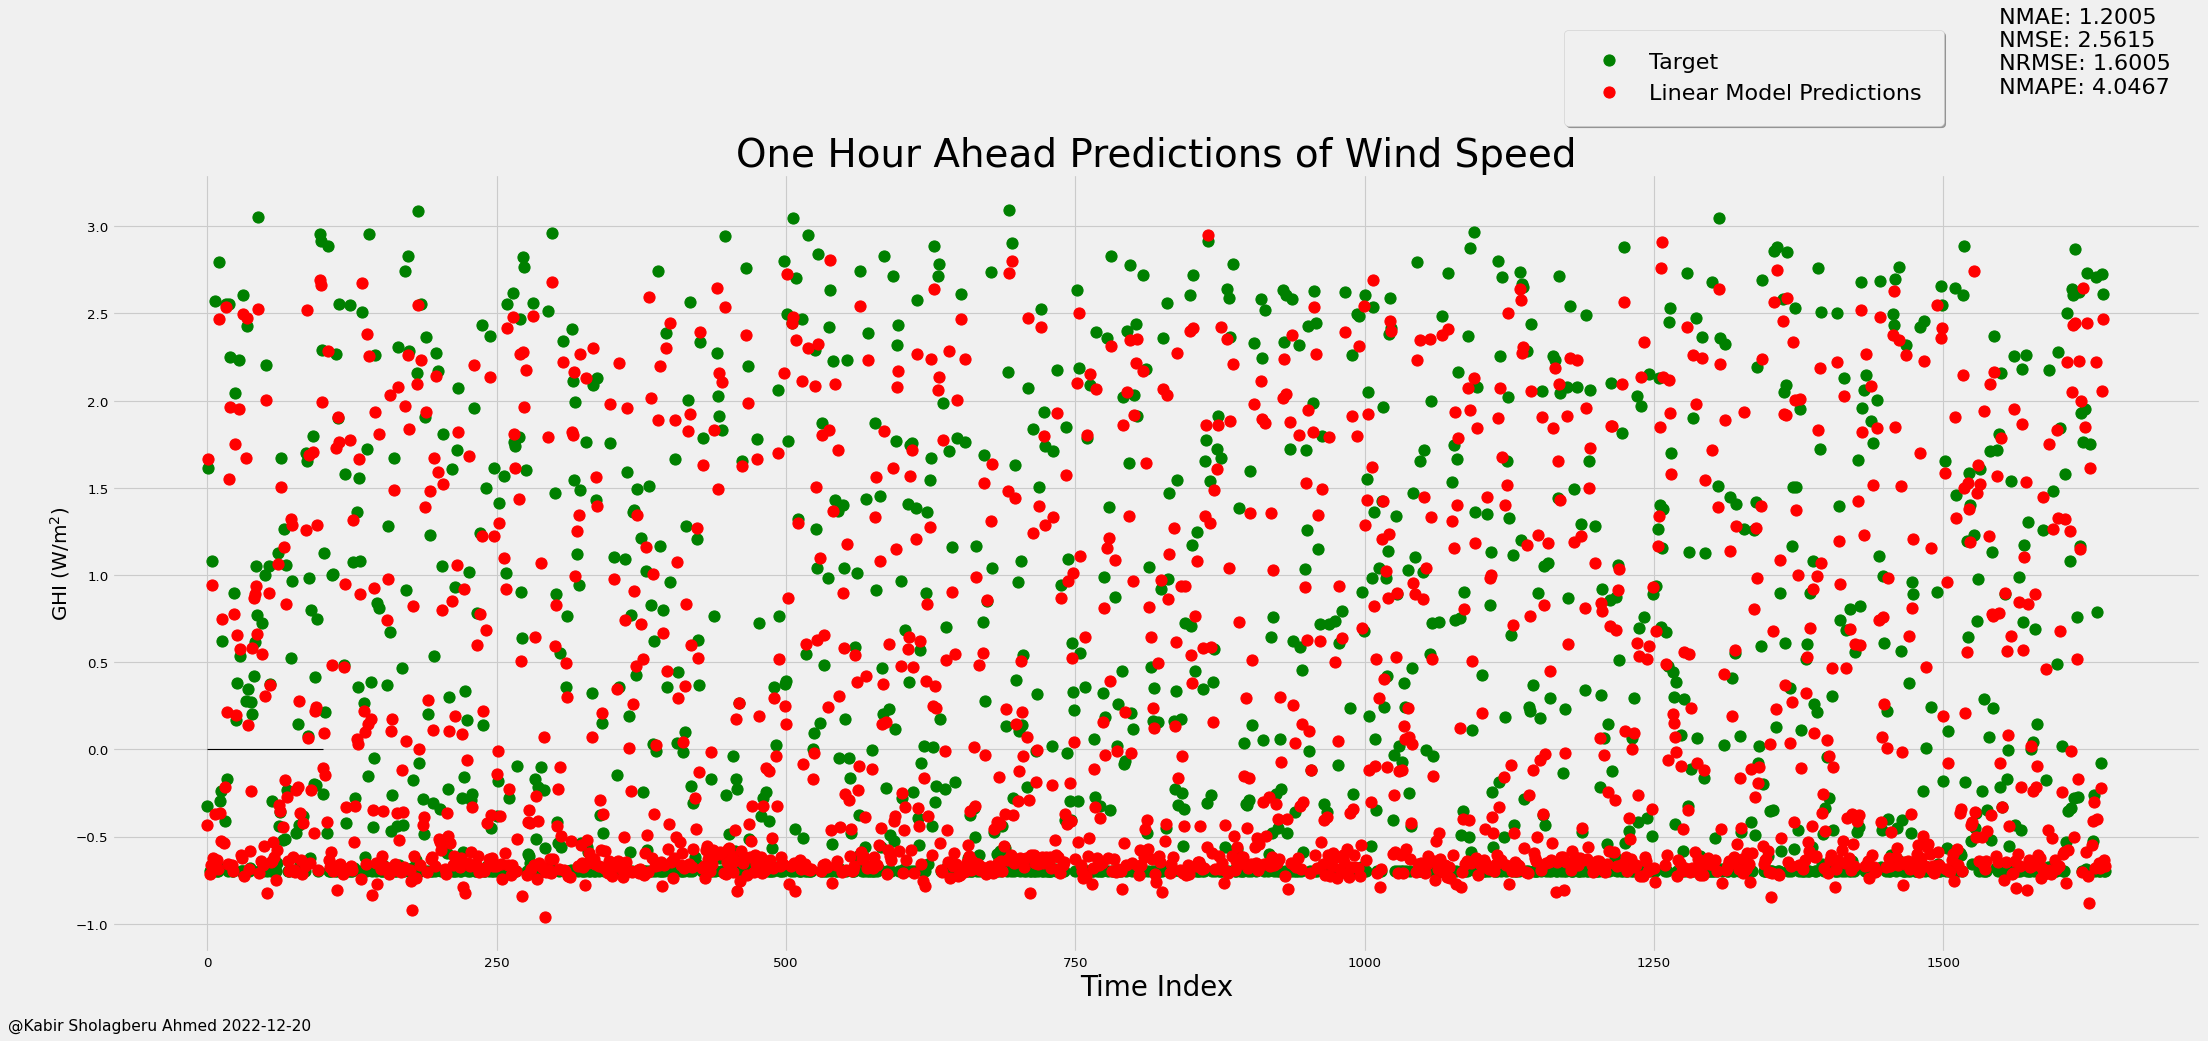

In [ ]:
today = date.today()
figure(figsize=(30, 12), dpi=80)
plt.clf()
plt.style.use('fivethirtyeight')
plt.plot(y_val, "bo", markersize=10, label='Target', color='green')
plt.plot(y_pred_linear, "bo", markersize=10, label='Linear Model Predictions', color='red')
plt.xlabel('Time Index', fontdict = {'fontsize': '25', 'fontweight' : '10'})
plt.ylabel('GHI (W/m$^2$)', fontdict = {'fontsize': '18', 'fontweight' : '15'})
plt.title('One Hour Ahead Predictions of Wind Speed', fontdict = {'fontsize': '35', 'fontweight' : '15'})
plt.hlines(0, 0, 100, linewidth=1)
plt.legend(loc = 2, bbox_to_anchor = (0.69, 1.2), ncol = 1, frameon=True, fontsize = '20', fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.text(0.90, 1.1, ' NMAE: {} \n NMSE: {} \n NRMSE: {} \n NMAPE: {}'.format(np.round(mae, 4), np.round(mse, 4), np.round(rmse, 4), np.round(mape, 4)),
         fontsize=20, fontfamily='Georgia', color='k', fontweight = 20,
         ha='left', va='bottom',
         transform=plt.gca().transAxes);
plt.annotate(f"@Kabir Sholagberu Ahmed {today}",
             xy=(1, 1),  xycoords='data',
             xytext=(-0.05, -0.10), textcoords='axes fraction',
             color='black')
plt.savefig('One Hour Ahead Predictions of Wind Speed.png')
plt.show()

###**HYPERPARAMETER TUNING - LINEAR MODEL**

(0.001, 0.01, 0.0, 2.0)

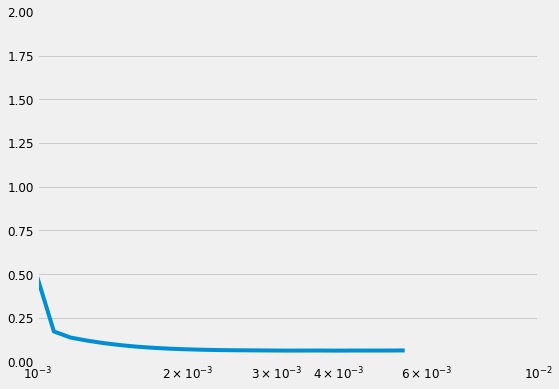

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "Linear_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

history = model.fit(X_train, y_train, epochs=200,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states, lr_schedule])

IPython.display.clear_output()

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-3, 1e-2, 0, 2])

**Obtain the Best Model Parameters, make Pedictions and Evaluate it**

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

optimizer = keras.optimizers.Adam(lr=3e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "Linear_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

model.fit(X_train, y_train, epochs=200,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states, lr_schedule])

IPython.display.clear_output()

y_pred_linear_optimized = model.predict(X_val)
performance['Optmized Linear Model'] = MAE(y_pred_linear_optimized, y_val)

# Evaluation in terms of other Metrics

mae = MAE(y_pred_linear_optimized, y_val)
mse = MSE(y_pred_linear_optimized, y_val)
rmse = RMSE(y_pred_linear_optimized, y_val)
mape = MAPE(y_pred_linear_optimized, y_val)

print('=============================================')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Square Error: {mse}')
print(f'Root Mean Square Error: {rmse}')
print(f'Mean Absolute Percentage Error: {mape}')
print('==============================================')

52/52 [==============================] - 0s 1ms/step
Mean Absolute Error: 1.2001990932185749
Mean Square Error: 2.5219291829349193
Root Mean Square Error: 1.588058305899037
Mean Absolute Percentage Error: 3.9628007759412234


**Visualize the Model**

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


##**DENSE Model**

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "Dense_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

model.fit(X_train, y_train, epochs=200,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states])

IPython.display.clear_output()

**Make Predictions and Perform Evaluations with the Model**

In [ ]:
y_pred_dense = model.predict(X_val)
performance['DENSE Model'] = MAE(y_pred_dense, y_val)

# Evaluation in terms of other Metrics

mae = MAE(y_pred_dense, y_val)
mse = MSE(y_pred_dense, y_val)
rmse = RMSE(y_pred_dense, y_val)
mape = MAPE(y_pred_dense, y_val)

print('=============================================')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Square Error: {mse}')
print(f'Root Mean Square Error: {rmse}')
print(f'Mean Absolute Percentage Error: {mape}')
print('==============================================')

52/52 [==============================] - 0s 1ms/step
Mean Absolute Error: 1.2005289960798529
Mean Square Error: 2.5615434998826627
Root Mean Square Error: 1.6004822710304112
Mean Absolute Percentage Error: 4.046747856793725


**View the Predictions**

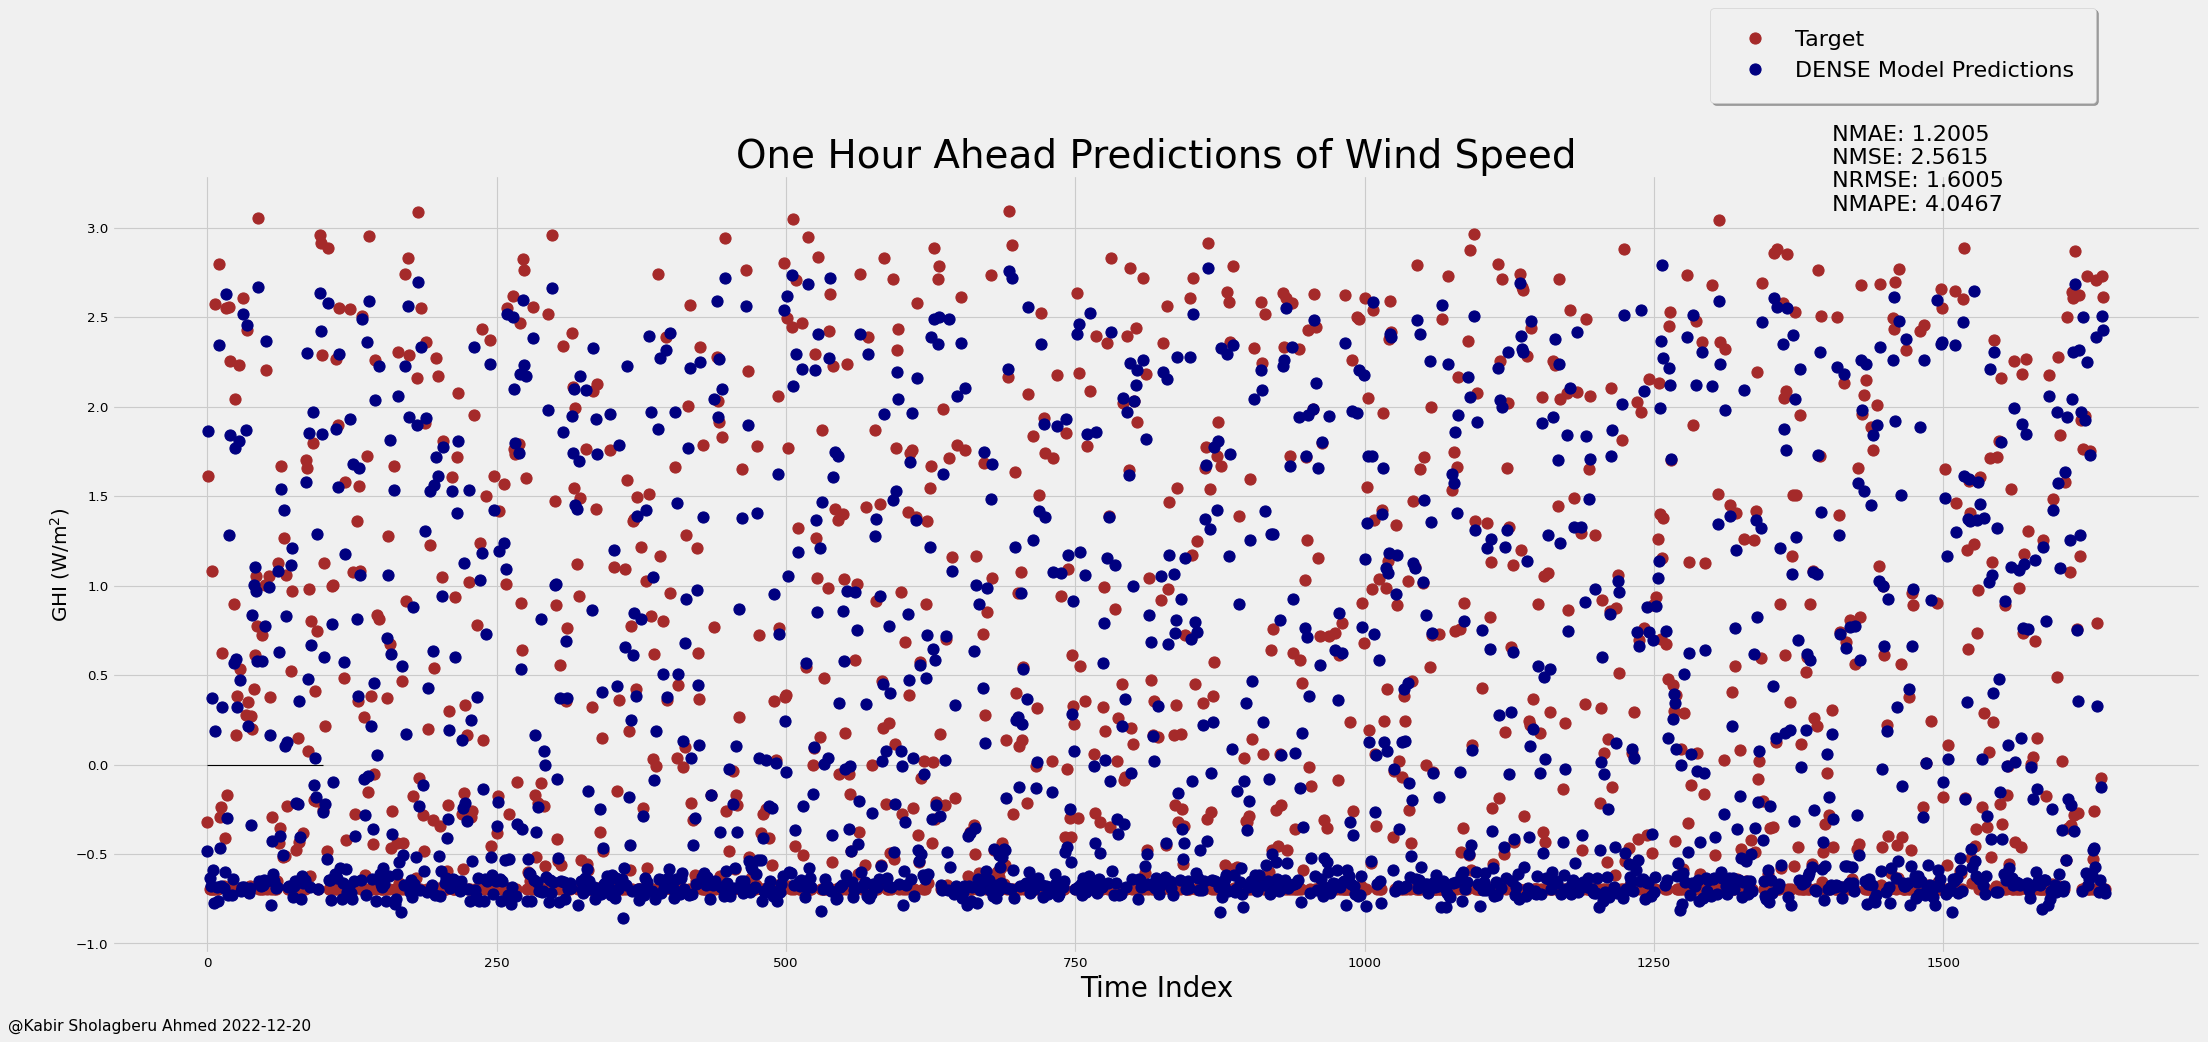

In [ ]:
today = date.today()
figure(figsize=(30, 12), dpi=80)
plt.clf()
plt.style.use('fivethirtyeight')
plt.plot(y_val, "bo", markersize=10, label='Target', color='brown')
plt.plot(y_pred_dense, "bo", markersize=10, label='DENSE Model Predictions', color='navy')
plt.xlabel('Time Index', fontdict = {'fontsize': '25', 'fontweight' : '10'})
plt.ylabel('GHI (W/m$^2$)', fontdict = {'fontsize': '18', 'fontweight' : '15'})
plt.title('One Hour Ahead Predictions of Wind Speed', fontdict = {'fontsize': '35', 'fontweight' : '15'})
plt.hlines(0, 0, 100, linewidth=1)
plt.legend(loc = 2, bbox_to_anchor = (0.76, 1.23), ncol = 1, frameon=True, fontsize = '20', fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.text(0.82, 0.95, ' NMAE: {} \n NMSE: {} \n NRMSE: {} \n NMAPE: {}'.format(np.round(mae, 4), np.round(mse, 4), np.round(rmse, 4), np.round(mape, 4)),
         fontsize=20, fontfamily='Georgia', color='k', fontweight = 20,
         ha='left', va='bottom',
         transform=plt.gca().transAxes);
plt.annotate(f"@Kabir Sholagberu Ahmed {today}",
             xy=(1, 1),  xycoords='data',
             xytext=(-0.05, -0.10), textcoords='axes fraction',
             color='black')
plt.savefig('One Hour Ahead Predictions of Wind Speed.png')
plt.show()

### **HYPERPARAMETER TUNING - DENSE MODEL**

(0.001, 0.01, 0.0, 1.0)

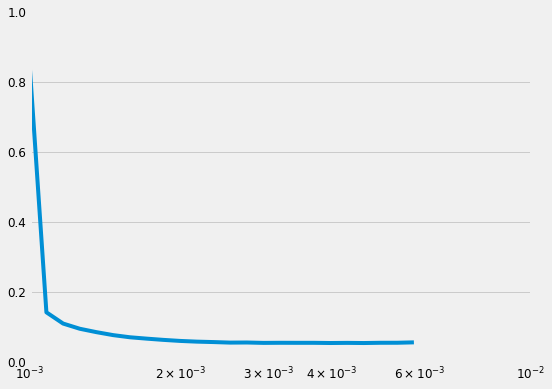

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "Dense_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

history = model.fit(X_train, y_train, epochs=200,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states, lr_schedule])

IPython.display.clear_output()

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-3, 1e-2, 0, 1])

**Obtain the Best Model Parameters, make Pedictions and Evaluate it**

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(lr=3.5e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "Dense_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

model.fit(X_train, y_train, epochs=200,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states, lr_schedule])

IPython.display.clear_output()

y_pred_dense_optimized = model.predict(X_val)
performance['Optmized Dense Model'] = MAE(y_pred_dense_optimized, y_val)

# Evaluation in terms of other Metrics

mae = MAE(y_pred_dense_optimized, y_val)
mse = MSE(y_pred_dense_optimized, y_val)
rmse = RMSE(y_pred_dense_optimized, y_val)
mape = MAPE(y_pred_dense_optimized, y_val)

print('=============================================')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Square Error: {mse}')
print(f'Root Mean Square Error: {rmse}')
print(f'Mean Absolute Percentage Error: {mape}')
print('==============================================')

52/52 [==============================] - 0s 1ms/step
Mean Absolute Error: 1.1852701049705796
Mean Square Error: 2.494360323896907
Root Mean Square Error: 1.579354400980637
Mean Absolute Percentage Error: 3.9525766590044125


**Visualize the Model**

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                250       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________


##**LSTM Model**

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Reshape the Input:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 24, 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1, 1))

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=False,
                    input_shape=(24, 1)),
  keras.layers.LSTM(100, return_sequences=True, stateful=False),
  keras.layers.Dense(1),
])

optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "Lstm_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

model.fit(X_train, y_train, epochs=200, batch_size=32,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states])

IPython.display.clear_output()

**Make Predictions and Perform Evaluations with the Model**

In [ ]:
y_pred_lstm = model.predict(X_val)
performance['LSTM Model'] = MAE(y_pred_lstm, y_val)

# Evaluation in terms of other Metrics

mae = MAE(y_pred_lstm, y_val)
mse = MSE(y_pred_lstm, y_val)
rmse = RMSE(y_pred_lstm, y_val)
mape = MAPE(y_pred_lstm, y_val)

print('=============================================')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Square Error: {mse}')
print(f'Root Mean Square Error: {rmse}')
print(f'Mean Absolute Percentage Error: {mape}')
print('==============================================')

52/52 [==============================] - 1s 3ms/step
Mean Absolute Error: 1.1713716060788077
Mean Square Error: 2.3546204319330926
Root Mean Square Error: 1.5344772503797808
Mean Absolute Percentage Error: 3.853554775169741


**View the Predictions**

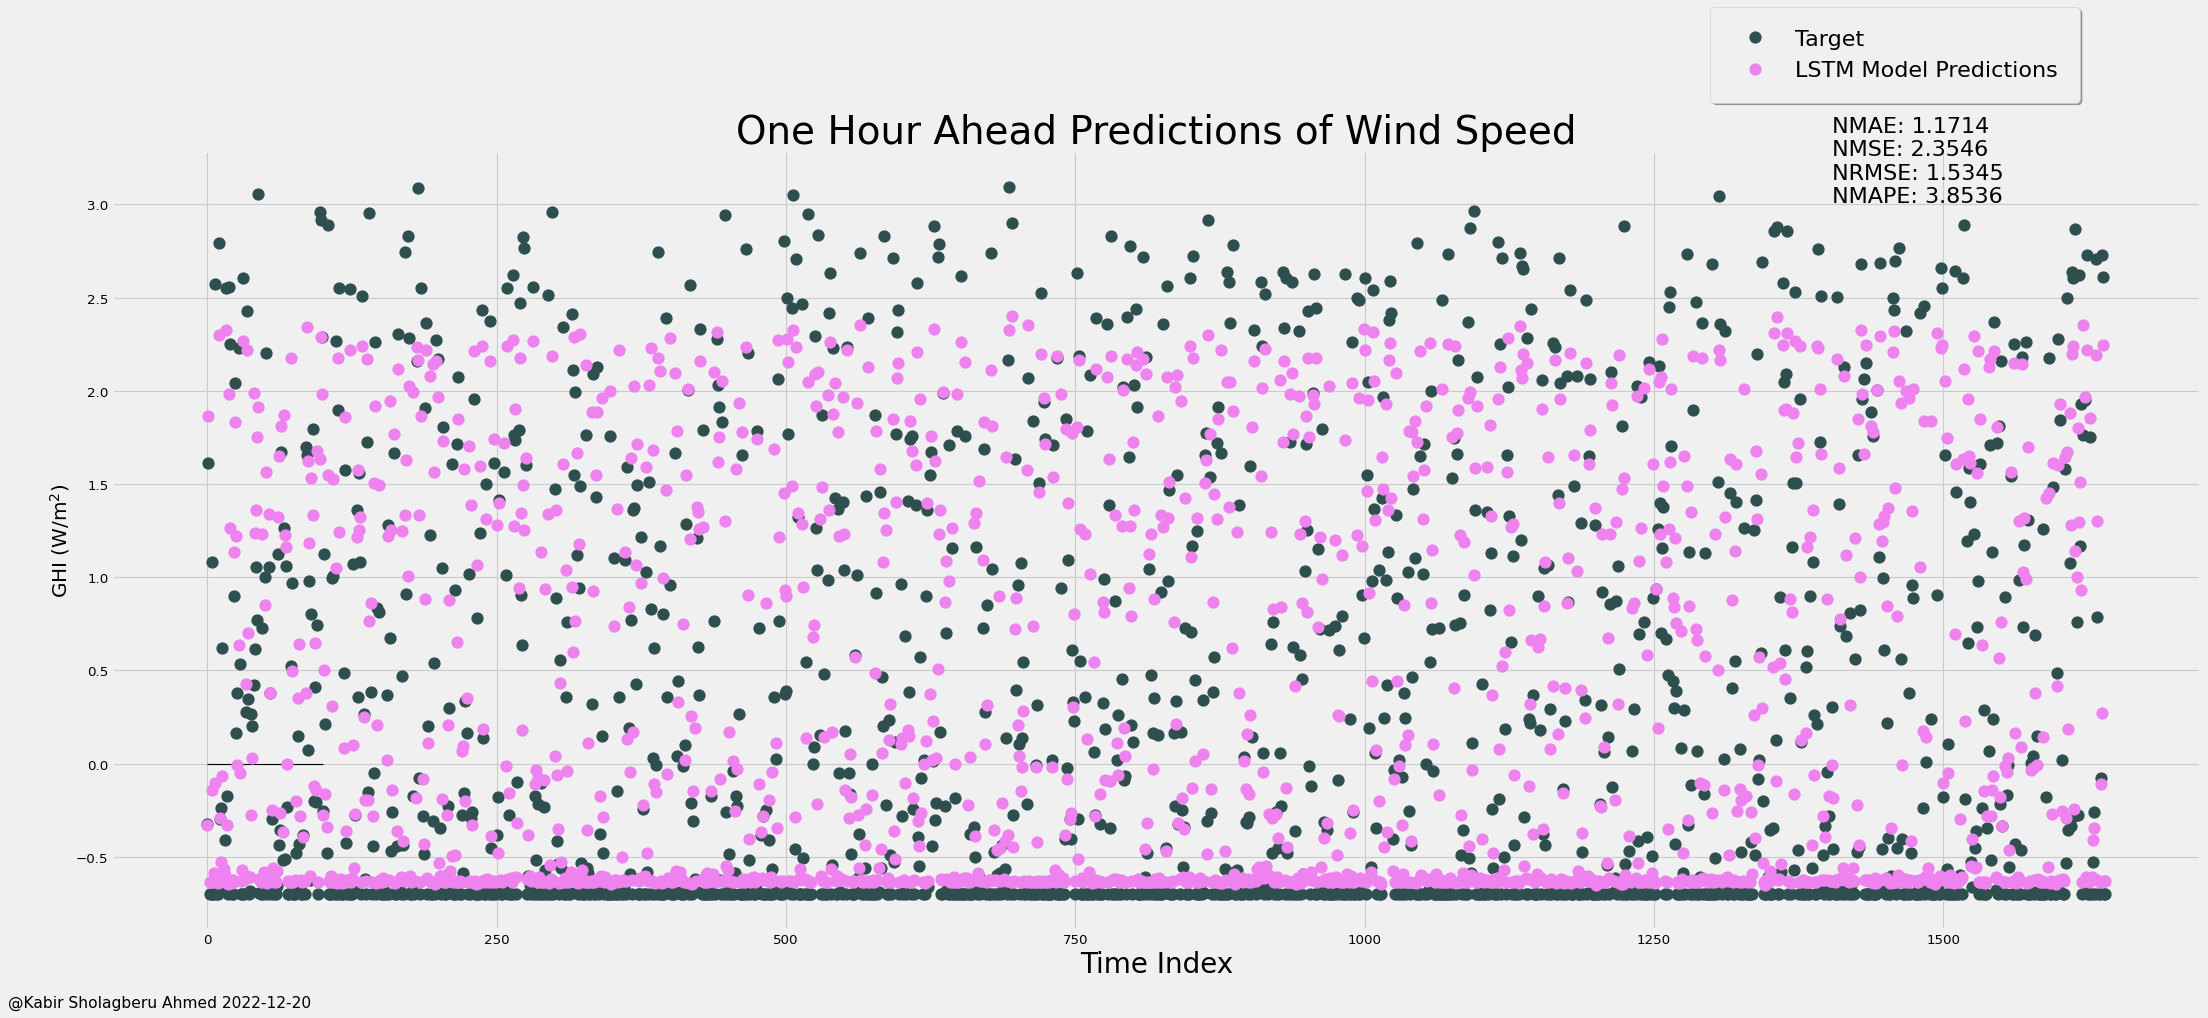

In [ ]:
y_pred_lstm = y_pred_lstm[:, -1, -1]
today = date.today()
figure(figsize=(30, 12), dpi=80)
plt.clf()
plt.style.use('fivethirtyeight')
plt.plot(y_val, "bo", markersize=10, label='Target', color='darkslategray')
plt.plot(y_pred_lstm, "bo", markersize=10, label='LSTM Model Predictions', color='violet')
plt.xlabel('Time Index', fontdict = {'fontsize': '25', 'fontweight' : '10'})
plt.ylabel('GHI (W/m$^2$)', fontdict = {'fontsize': '18', 'fontweight' : '15'})
plt.title('One Hour Ahead Predictions of Wind Speed', fontdict = {'fontsize': '35', 'fontweight' : '15'})
plt.hlines(0, 0, 100, linewidth=1)
plt.legend(loc = 2, bbox_to_anchor = (0.76, 1.2), ncol = 1, frameon=True, fontsize = '20', fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.text(0.82, 0.93, ' NMAE: {} \n NMSE: {} \n NRMSE: {} \n NMAPE: {}'.format(np.round(mae, 4), np.round(mse, 4), np.round(rmse, 4), np.round(mape, 4)),
         fontsize=20, fontfamily='Georgia', color='k', fontweight = 20,
         ha='left', va='bottom',
         transform=plt.gca().transAxes);
plt.annotate(f"@Kabir Sholagberu Ahmed {today}",
             xy=(1, 1),  xycoords='data',
             xytext=(-0.05, -0.10), textcoords='axes fraction',
             color='black')
plt.savefig('One Hour Ahead Predictions of Wind Speed.png')
plt.show()

###**HYPERPARAMETER TUNING - LSTM MODEL**

(0.001, 0.01, 0.0, 2.0)

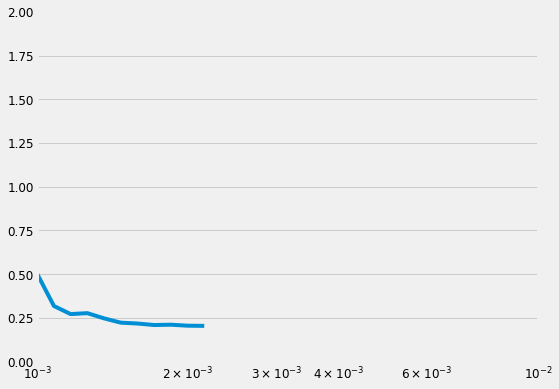

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=False,
                    input_shape=(24, 1)),
  keras.layers.LSTM(100, return_sequences=True, stateful=False),
  keras.layers.Dense(1),
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "Lstm_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

history = model.fit(X_train, y_train, epochs=200,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states, lr_schedule])

IPython.display.clear_output()

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-3, 1e-2, 0, 2])

**Obtain the Best Model Parameters, make Pedictions and Evaluate it**

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=False,
                    input_shape=(24, 1)),
  keras.layers.LSTM(100, return_sequences=True, stateful=False),
  keras.layers.Dense(1),
])

optimizer = keras.optimizers.Adam(lr=2.5e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "Lstm_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

model.fit(X_train, y_train, epochs=200,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states, lr_schedule])

IPython.display.clear_output()

y_pred_lstm_optimized = model.predict(X_val)
performance['Optmized Lstm Model'] = MAE(y_pred_lstm_optimized, y_val)

# Evaluation in terms of other Metrics

mae = MAE(y_pred_lstm_optimized, y_val)
mse = MSE(y_pred_lstm_optimized, y_val)
rmse = RMSE(y_pred_lstm_optimized, y_val)
mape = MAPE(y_pred_lstm_optimized, y_val)

print('=============================================')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Square Error: {mse}')
print(f'Root Mean Square Error: {rmse}')
print(f'Mean Absolute Percentage Error: {mape}')
print('==============================================')

52/52 [==============================] - 1s 3ms/step
Mean Absolute Error: 1.1615736551661475
Mean Square Error: 2.304635544401092
Root Mean Square Error: 1.5181026132646935
Mean Absolute Percentage Error: 3.82544077387464


**Visualize the Model**

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 24, 100)           80400     
                                                                 
 dense (Dense)               (None, 24, 1)             101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


##**1-Dimensional Convolutional Model**

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Reshape the Input:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 24, 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1, 1))

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "tcnn_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

model.fit(X_train, y_train, epochs=200, batch_size=32,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states])

IPython.display.clear_output()

**Make Predictions and Perform Evaluations with the Model**

In [ ]:
model = keras.models.load_model("tcnn_Model.h5")
y_pred_tcnn = model.predict(X_val)
performance['TCNN Model'] = MAE(y_pred_tcnn, y_val)

# Evaluation in terms of other Metrics

mae = MAE(y_pred_tcnn, y_val)
mse = MSE(y_pred_tcnn, y_val)
rmse = RMSE(y_pred_tcnn, y_val)
mape = MAPE(y_pred_tcnn, y_val)

print('=============================================')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Square Error: {mse}')
print(f'Root Mean Square Error: {rmse}')
print(f'Mean Absolute Percentage Error: {mape}')
print('==============================================')

52/52 [==============================] - 0s 2ms/step
Mean Absolute Error: 1.1277554532603014
Mean Square Error: 2.226319773564389
Root Mean Square Error: 1.4920857125394604
Mean Absolute Percentage Error: 3.5945303869124867


**View the Predictions**

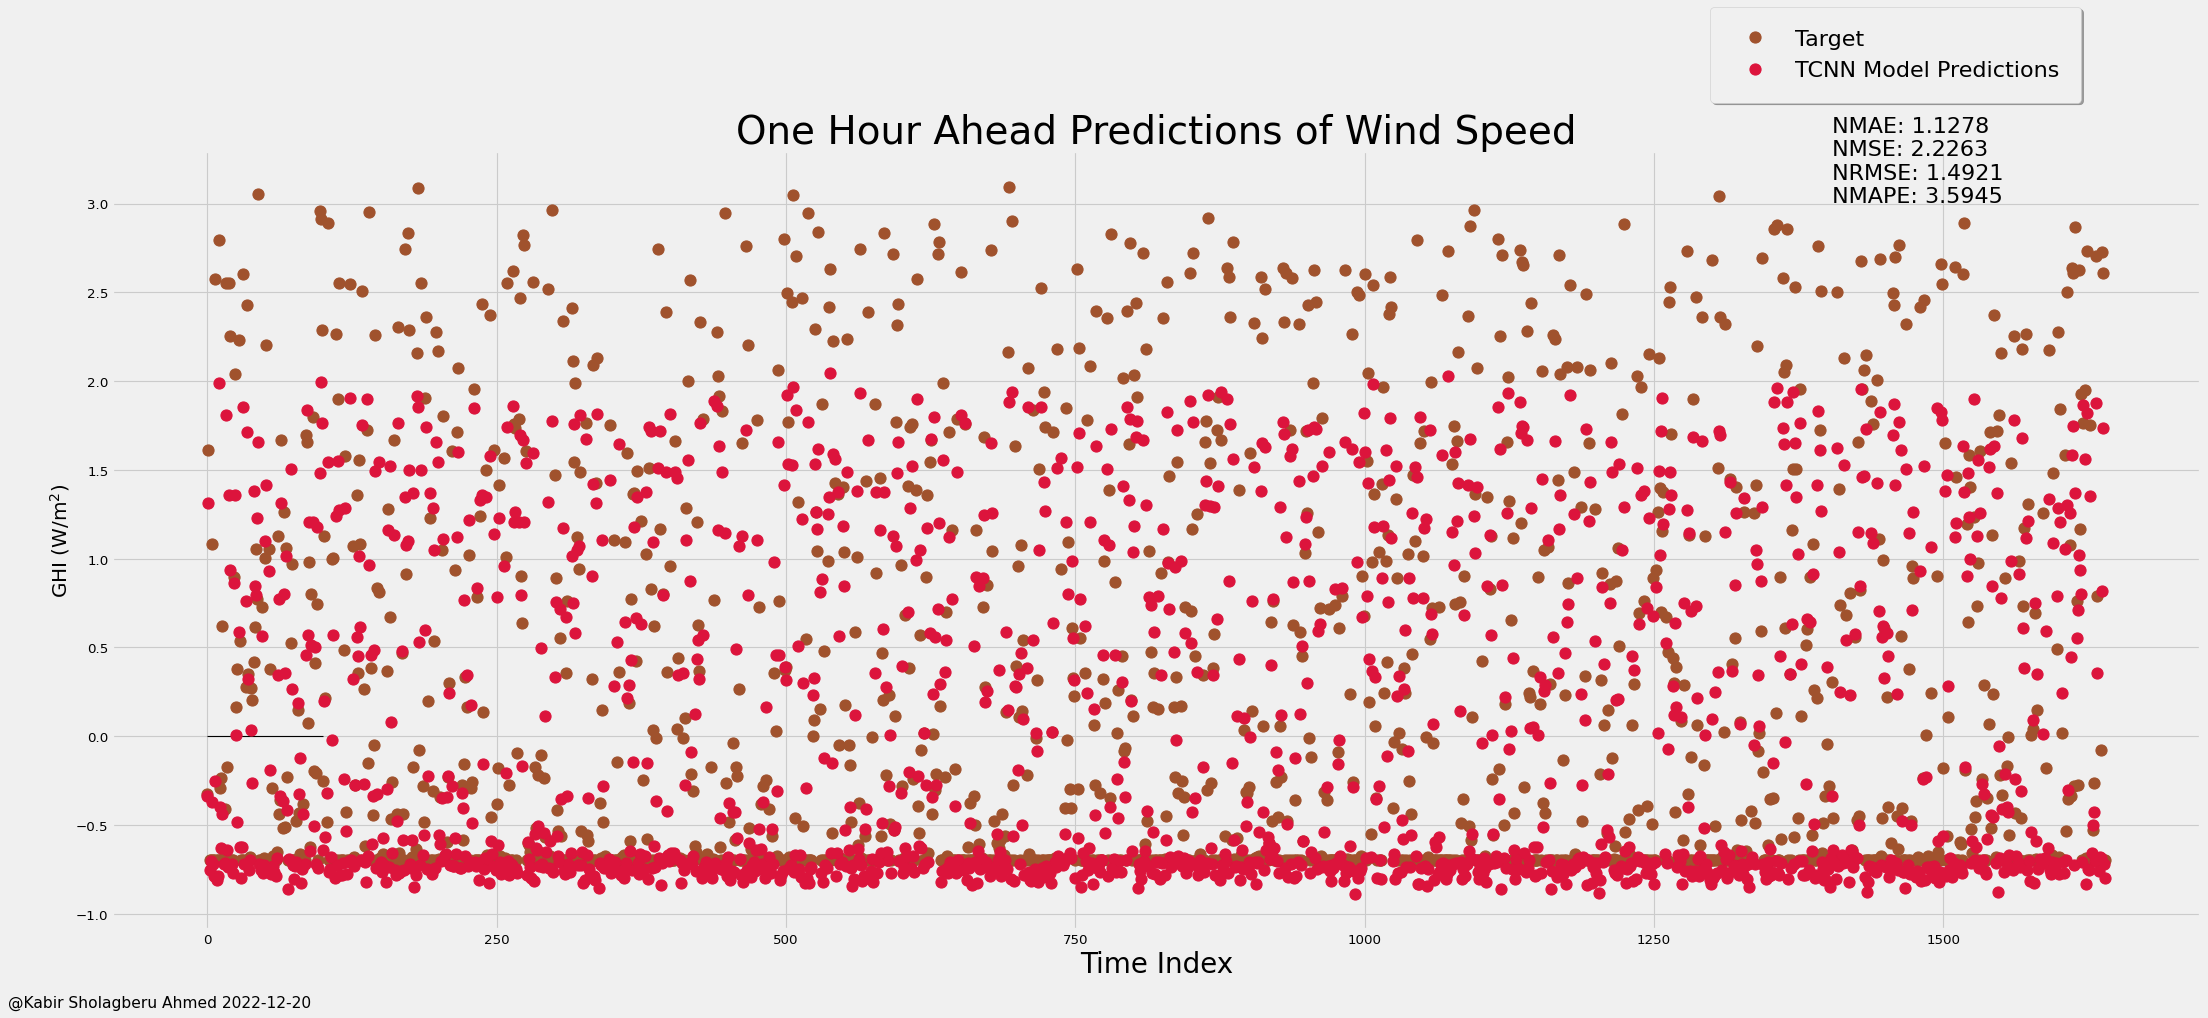

In [ ]:
y_pred_tcnn = y_pred_tcnn[:, -1, -1]
today = date.today()
figure(figsize=(30, 12), dpi=80)
plt.clf()
plt.style.use('fivethirtyeight')
plt.plot(y_val, "bo", markersize=10, label='Target', color='sienna')
plt.plot(y_pred_tcnn, "bo", markersize=10, label='TCNN Model Predictions', color='crimson')
plt.xlabel('Time Index', fontdict = {'fontsize': '25', 'fontweight' : '10'})
plt.ylabel('GHI (W/m$^2$)', fontdict = {'fontsize': '18', 'fontweight' : '15'})
plt.title('One Hour Ahead Predictions of Wind Speed', fontdict = {'fontsize': '35', 'fontweight' : '15'})
plt.hlines(0, 0, 100, linewidth=1)
plt.legend(loc = 2, bbox_to_anchor = (0.76, 1.2), ncol = 1, frameon=True, fontsize = '20', fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.text(0.82, 0.93, ' NMAE: {} \n NMSE: {} \n NRMSE: {} \n NMAPE: {}'.format(np.round(mae, 4), np.round(mse, 4), np.round(rmse, 4), np.round(mape, 4)),
         fontsize=20, fontfamily='Georgia', color='k', fontweight = 20,
         ha='left', va='bottom',
         transform=plt.gca().transAxes);
plt.annotate(f"@Kabir Sholagberu Ahmed {today}",
             xy=(1, 1),  xycoords='data',
             xytext=(-0.05, -0.10), textcoords='axes fraction',
             color='black')
plt.savefig('One Hour Ahead Predictions of Wind Speed.png')
plt.show()

##**HYPERPARAMETER TUNING - TCNN MODEL**

(0.001, 0.01, 0.0, 2.0)

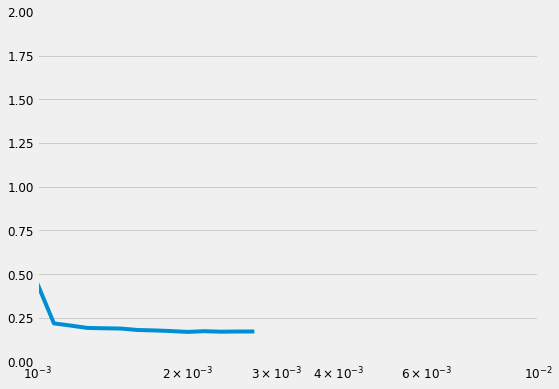

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "tcnn_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

history = model.fit(X_train, y_train, epochs=200,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states, lr_schedule])

IPython.display.clear_output()

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-3, 1e-2, 0, 2])

**Obtain the Best Model Parameters, make Pedictions and Evaluate it**

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

optimizer = keras.optimizers.Adam(lr=6.3e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "tcnn_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

model.fit(X_train, y_train, epochs=200,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states, lr_schedule])

IPython.display.clear_output()

y_pred_tcnn_optimized = model.predict(X_val)
performance['Optmized TCNN Model'] = MAE(y_pred_tcnn_optimized, y_val)

# Evaluation in terms of other Metrics

mae = MAE(y_pred_tcnn_optimized, y_val)
mse = MSE(y_pred_tcnn_optimized, y_val)
rmse = RMSE(y_pred_tcnn_optimized, y_val)
mape = MAPE(y_pred_tcnn_optimized, y_val)

print('=============================================')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Square Error: {mse}')
print(f'Root Mean Square Error: {rmse}')
print(f'Mean Absolute Percentage Error: {mape}')
print('==============================================')

52/52 [==============================] - 0s 2ms/step
Mean Absolute Error: 1.2009869420516524
Mean Square Error: 2.484021751243006
Root Mean Square Error: 1.57607796483645
Mean Absolute Percentage Error: 4.07286470100238


**Visualize the Model**

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          96        
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_2 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_3 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_4 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_5 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_6 (Conv1D)           (None, None, 1)           3

##**Recurrent Autoencoders**

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Reshape the Input:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 24, 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1, 1))

recurrent_encoder = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=False,
                    input_shape=(24, 1)),
  keras.layers.LSTM(100, return_sequences=True, stateful=False),
  keras.layers.Dense(1)
])

recurrent_decoder = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=False,
                    input_shape=(24, 1)),
  keras.layers.LSTM(100, return_sequences=True, stateful=False),
  keras.layers.Dense(1),
])

model = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "Recurrent_Autoencoder_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

model.fit(X_train, y_train, epochs=200, batch_size=32,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states])

IPython.display.clear_output()

**Make Predictions and Perform Evaluations with the Model**

In [ ]:
model = keras.models.load_model("Recurrent_Autoencoder_Model.h5")
y_pred_ae = model.predict(X_val)
performance['AUTOENCODER Model'] = MAE(y_pred_ae, y_val)

# Evaluation in terms of other Metrics

mae = MAE(y_pred_ae, y_val)
mse = MSE(y_pred_ae, y_val)
rmse = RMSE(y_pred_ae, y_val)
mape = MAPE(y_pred_ae, y_val)

print('=============================================')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Square Error: {mse}')
print(f'Root Mean Square Error: {rmse}')
print(f'Mean Absolute Percentage Error: {mape}')
print('==============================================')

52/52 [==============================] - 2s 6ms/step
Mean Absolute Error: 1.0689367801743361
Mean Square Error: 1.872395713928827
Root Mean Square Error: 1.3683551125087474
Mean Absolute Percentage Error: 3.1438611780001677


**View the Predictions**

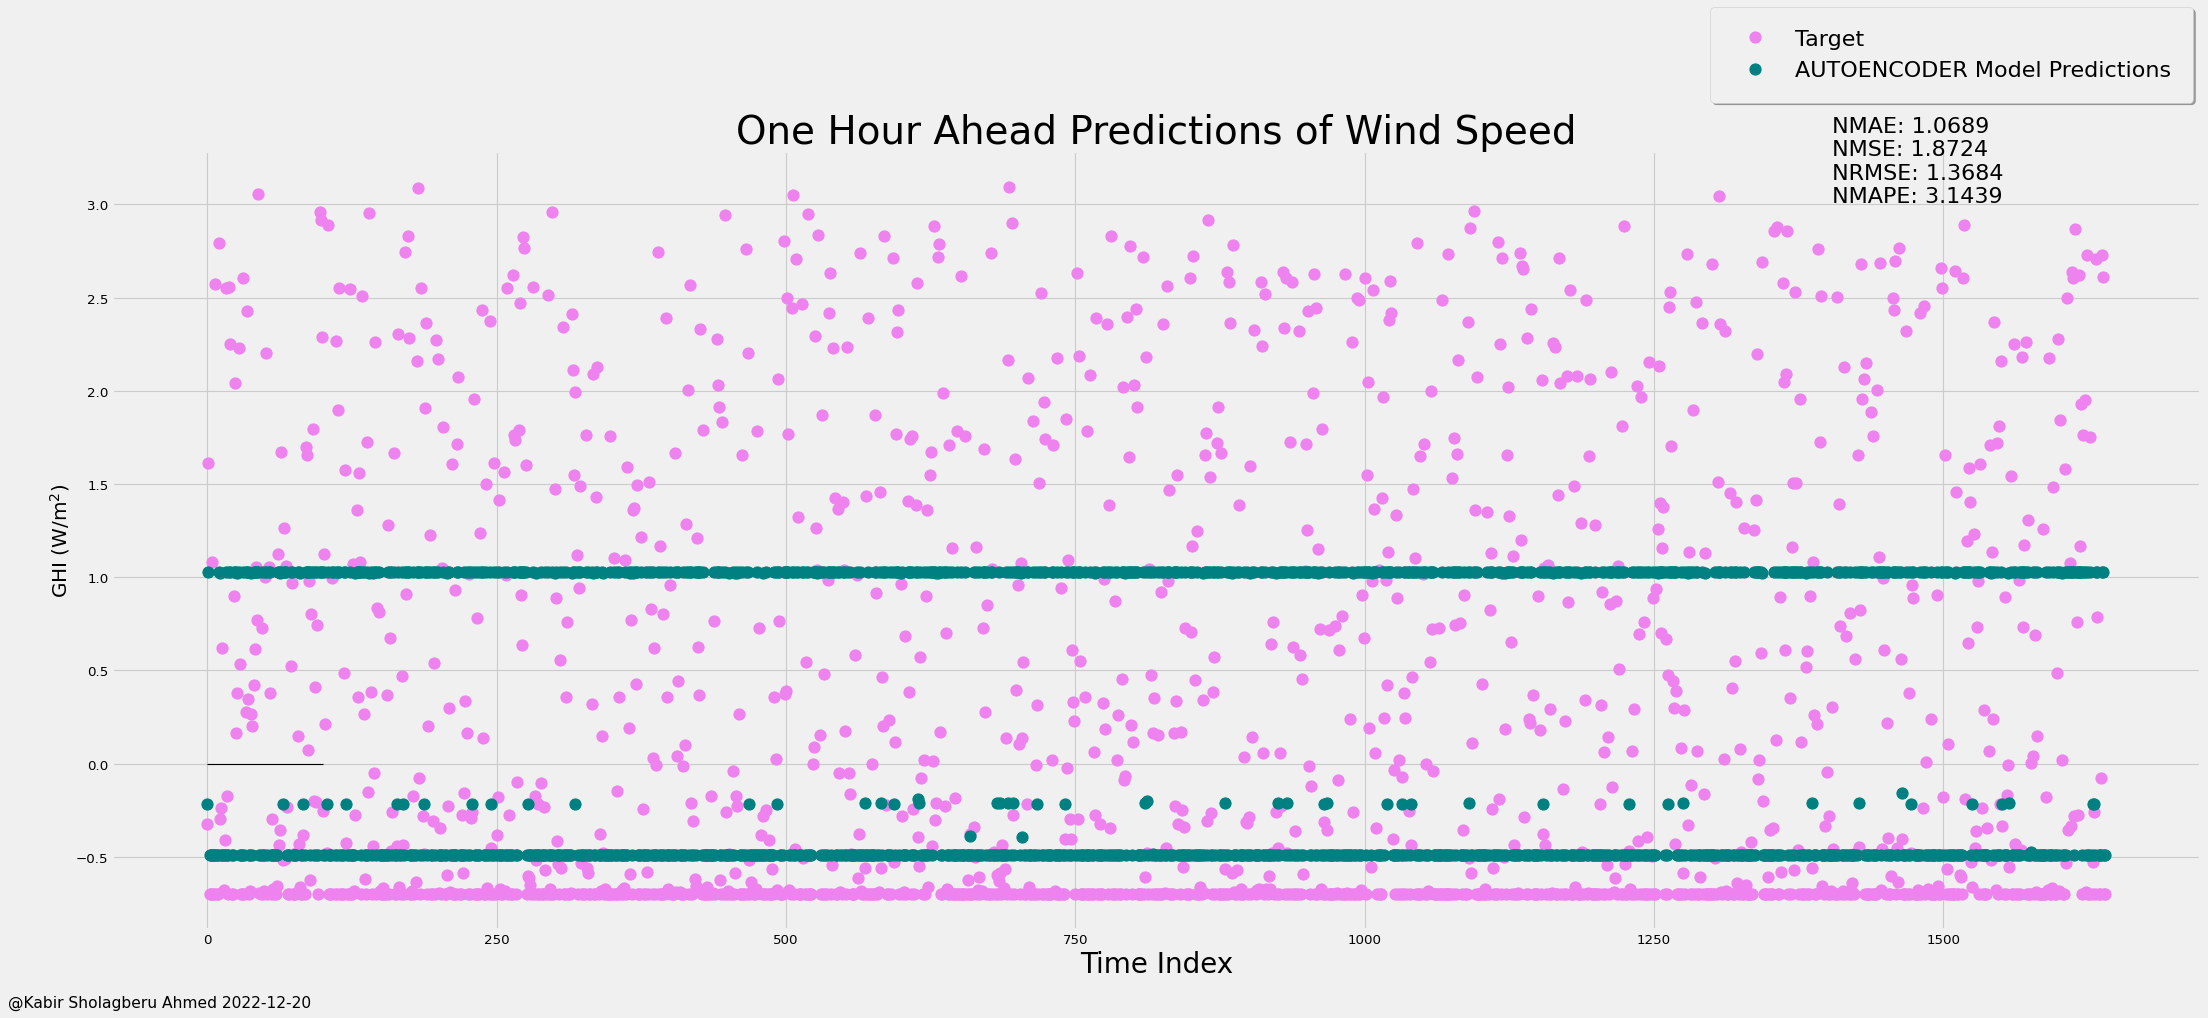

In [ ]:
y_pred_ae = y_pred_ae[:, -1, -1]
today = date.today()
figure(figsize=(30, 12), dpi=80)
plt.clf()
plt.style.use('fivethirtyeight')
plt.plot(y_val, "bo", markersize=10, label='Target', color='violet')
plt.plot(y_pred_ae, "bo", markersize=10, label='AUTOENCODER Model Predictions', color='teal')
plt.xlabel('Time Index', fontdict = {'fontsize': '25', 'fontweight' : '10'})
plt.ylabel('GHI (W/m$^2$)', fontdict = {'fontsize': '18', 'fontweight' : '15'})
plt.title('One Hour Ahead Predictions of Wind Speed', fontdict = {'fontsize': '35', 'fontweight' : '15'})
plt.hlines(0, 0, 100, linewidth=1)
plt.legend(loc = 2, bbox_to_anchor = (0.76, 1.2), ncol = 1, frameon=True, fontsize = '20', fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.text(0.82, 0.93, ' NMAE: {} \n NMSE: {} \n NRMSE: {} \n NMAPE: {}'.format(np.round(mae, 4), np.round(mse, 4), np.round(rmse, 4), np.round(mape, 4)),
         fontsize=20, fontfamily='Georgia', color='k', fontweight = 20,
         ha='left', va='bottom',
         transform=plt.gca().transAxes);
plt.annotate(f"@Kabir Sholagberu Ahmed {today}",
             xy=(1, 1),  xycoords='data',
             xytext=(-0.05, -0.10), textcoords='axes fraction',
             color='black')
plt.savefig('One Hour Ahead Predictions of Wind Speed.png')
plt.show()

##**HYPERPARAMETER TUNING - AUTOENCODER MODEL**

(0.001, 0.01, 0.0, 2.0)

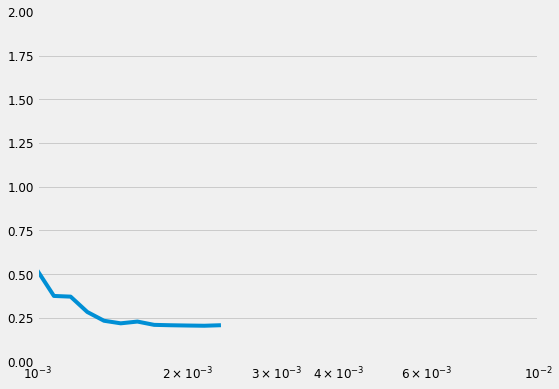

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

recurrent_encoder = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=False,
                    input_shape=(24, 1)),
  keras.layers.LSTM(100, return_sequences=True, stateful=False),
  keras.layers.Dense(1)
])

recurrent_decoder = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=False,
                    input_shape=(24, 1)),
  keras.layers.LSTM(100, return_sequences=True, stateful=False),
  keras.layers.Dense(1),
])

model = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "AUTOENCODER_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

history = model.fit(X_train, y_train, epochs=200,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states, lr_schedule])

IPython.display.clear_output()

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-3, 1e-2, 0, 2])

**Obtain the Best Model Parameters, make Pedictions and Evaluate it**

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

recurrent_encoder = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=False,
                    input_shape=(24, 1)),
  keras.layers.LSTM(100, return_sequences=True, stateful=False),
  keras.layers.Dense(1)
])

recurrent_decoder = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=False,
                    input_shape=(24, 1)),
  keras.layers.LSTM(100, return_sequences=True, stateful=False),
  keras.layers.Dense(1),
])

model = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

optimizer = keras.optimizers.Adam(lr=2.5e-3)
model.compile(loss="mse", optimizer=optimizer)

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "AUTOENCODER_Model.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

model.fit(X_train, y_train, epochs=200,
          validation_data = (X_val, y_val),
          callbacks=[early_stopping, model_checkpoint, reset_states, lr_schedule])

IPython.display.clear_output()

y_pred_ae_optimized = model.predict(X_val)
performance['Optmized AUTOENCODER Model'] = MAE(y_pred_ae_optimized, y_val)

# Evaluation in terms of other Metrics

mae = MAE(y_pred_ae_optimized, y_val)
mse = MSE(y_pred_ae_optimized, y_val)
rmse = RMSE(y_pred_ae_optimized, y_val)
mape = MAPE(y_pred_ae_optimized, y_val)

print('=============================================')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Square Error: {mse}')
print(f'Root Mean Square Error: {rmse}')
print(f'Mean Absolute Percentage Error: {mape}')
print('==============================================')

52/52 [==============================] - 2s 5ms/step
Mean Absolute Error: 1.1223345088556718
Mean Square Error: 2.140446454729653
Root Mean Square Error: 1.4630264709599936
Mean Absolute Percentage Error: 3.4425698574734613


**Visualize the Model**

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 24, 1)             121301    
                                                                 
 sequential_1 (Sequential)   (None, 24, 1)             121301    
                                                                 
Total params: 242,602
Trainable params: 242,602
Non-trainable params: 0
_________________________________________________________________


##**Comparison of the Model's Forecast at 1-Hour Ahead based on MAE, MSE, RMSE, MAPE Metrics**

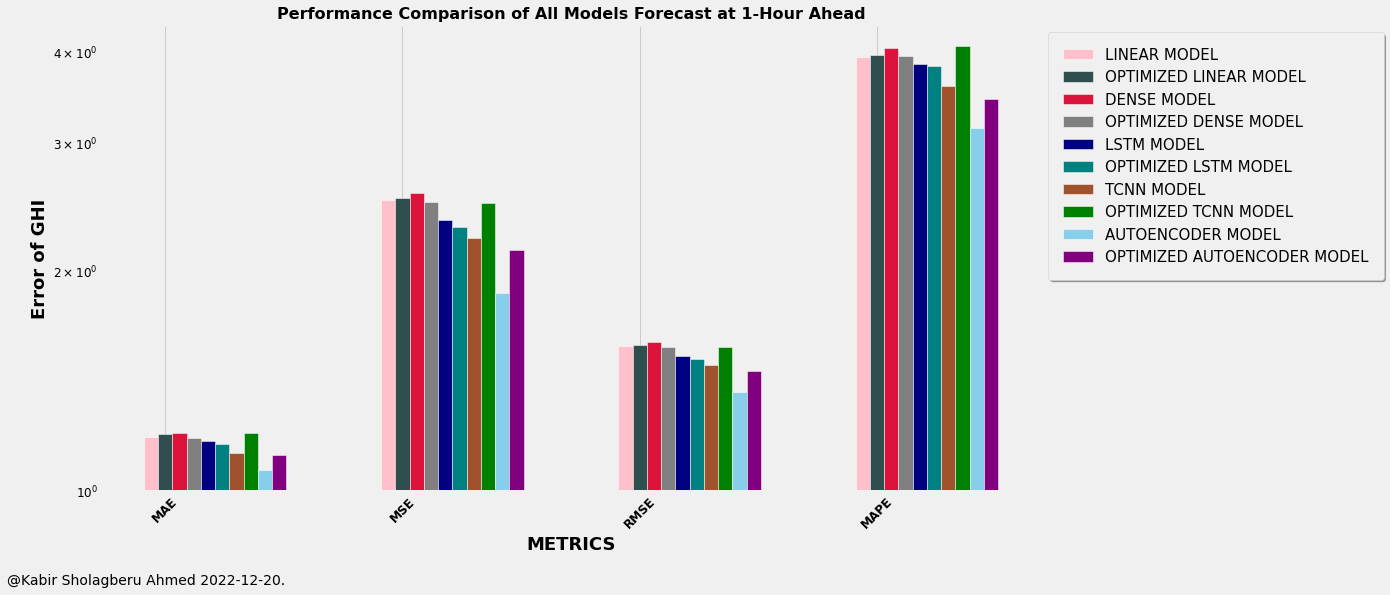

In [ ]:
today = date.today()
LINEAR = [1.1866, 2.5039, 1.5823, 3.9378]
OPT_LINEAR = [1.2001, 2.5219, 1.5880, 3.9628]
DENSE = [1.2005, 2.5615, 1.6004, 4.0467]
OPT_DENSE = [1.1852, 2.4943, 1.5793, 3.9525]
LSTM = [1.1713, 2.3546, 1.5344, 3.8535]
OPT_LSTM = [1.1615, 2.3046, 1.5181, 3.8254]
TCNN = [1.1277, 2.2263, 1.4920, 3.5945]
OPT_TCNN = [1.2009, 2.4840, 1.5760, 4.0728]
AUTOENCODER = [1.0689, 1.8723, 1.3683, 3.1438]
OPT_AUTOENCODER = [1.1223, 2.1404, 1.4630, 3.4425]

N = 4
x = np.arange(N)
width = 0.3

# Set position of bar on X axis
#r1 = np.arange(0, len(LINEAR) * 5, 5)
r1 = np.arange(0, len(LINEAR) * 5, 5)
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]
r4 = [x + width for x in r3]
r5 = [x + width for x in r4]
r6 = [x + width for x in r5]
r7 = [x + width for x in r6]
r8 = [x + width for x in r7]
r9 = [x + width for x in r8]
r10 = [x + width for x in r9]

plt.figure(figsize=(15, 8))
plt.clf()
plt.style.use('fivethirtyeight')
plt.ylabel("Error of GHI", weight='bold').set_fontsize('18')
#plt.bar(r1, NAIVE, width, edgecolor='white', label='NAIVE', color='violet')
plt.bar(r1, LINEAR, width, edgecolor='white', label='LINEAR MODEL', color='pink')
plt.bar(r2, OPT_LINEAR, width, edgecolor='white', label='OPTIMIZED LINEAR MODEL', color='darkslategrey')
plt.bar(r3, DENSE, width, edgecolor='white', label='DENSE MODEL', color='crimson')
plt.bar(r4, OPT_DENSE, width, edgecolor='white', label='OPTIMIZED DENSE MODEL', color='gray')
plt.bar(r5, LSTM, width, edgecolor='white', label='LSTM MODEL', color='navy')
plt.bar(r6, OPT_LSTM, width, edgecolor='white', label='OPTIMIZED LSTM MODEL', color='teal')
plt.bar(r7, TCNN, width, edgecolor='white', label='TCNN MODEL', color='sienna')
plt.bar(r8, OPT_TCNN, width, edgecolor='white', label='OPTIMIZED TCNN MODEL', color='green')
plt.bar(r9, AUTOENCODER, width, edgecolor='white', label='AUTOENCODER MODEL', color='skyblue')
plt.bar(r10, OPT_AUTOENCODER, width, edgecolor='white', label='OPTIMIZED AUTOENCODER MODEL', color='purple')

plt.xlabel('METRICS', weight='bold').set_fontsize('18')
plt.xticks([r + width for r in range(0, len(LINEAR) * 5, 5)], ['MAE', 'MSE', 'RMSE', 'MAPE'], rotation=45, size = 12, fontweight='bold')
plt.title('Performance Comparison of All Models Forecast at 1-Hour Ahead', size = 16, fontweight='bold')
plt.legend(loc = 'best', bbox_to_anchor = (1.0, 1.0), ncol = 1, frameon=True, fontsize = '15',
           fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.grid(True)
plt.yscale('log')
plt.annotate(f"@Kabir Sholagberu Ahmed {today}.",
             xy=(1, 1),  xycoords='data',
             xytext=(-0.1, -0.20), textcoords='axes fraction',
             color='black')
plt.savefig('Comparison of the Models Forecast at 1-Hour Ahead based on MAE, MSE, RMSE & MAPE Metrics.png')

#**Deploy the model to Google Cloud AI Platform**

1. First login to the Google Account, and go to Google Cloud Platform (GCP).

2. Activate the Account

3. Create a Project

4. Access Google Cloud Storage and create a bucket

5. Upload the best Trained Model for both Wind Speed and GHI Models

6. Configure the AI Platform and create the Model

7. Create the Model Version, and deploy the Model to the Cloud.

8. Use the Cloud Prediction service to make predictions by first creating a service account for the Application, select ML Engine developer role, and create key to export the service account private key.

9. Write a Python script that will use the service account private key, Google API Client Library and others to query the prediction service.